In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import warnings

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=720)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 全撈 
one_year_ago_str = '20210101'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)

sub_category_list = pd.read_sql(query_sub_category, engine)



In [11]:
import numpy as np

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

stock_df_raw[(stock_df_raw['Date'] == '2024-04-01') & (stock_df_raw['成交筆數'] < 100) & (stock_df_raw['收盤價'] < 100)].copy() 
stock_df_raw[(stock_df_raw['Date'] > '2024-04-01') & (stock_df_raw['證券代號'] == '1110' )]['成交筆數'].iloc[0]

30

運算量實在是有點大

In [13]:
# 想想看要怎麼搞出 ㄏ 字形 參考寶碩 海報哥


stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2024-04-10' ) & (stock_df_raw['Date']<='2024-04-30' ) & (stock_df_raw['證券代號'] == '8028' ) ]['Date']

collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', '明天收盤價', 'Date'])

for day in stock_date_list:

        stock_df_today = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['成交筆數'] < 100) & (stock_df_raw['收盤價'] < 100)].copy() 

        stock_id_list = stock_df_today['證券代號'].tolist()

        for stock_id in stock_id_list:

                # 有day 跟 stock_id
                stock_his = stock_df_raw[(stock_df_raw['Date'] < day) & (stock_df_raw['證券代號'] == stock_id )]
                # 過去
                volume_mean = stock_his['成交筆數'].rolling(120).mean().iloc[-1]
                today_close = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                stock_name = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )]['證券名稱'].iloc[0]

                stock_af_volume = stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['成交筆數'].iloc[0]
                stock_af_price  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                # 今天收盤很靠近季線
                if( (volume_mean < 100) & (stock_af_volume > 1000) & (stock_af_price > today_close * 1.05)):

                        result_df = pd.DataFrame({
                                '證券代號': [ stock_id],
                                '證券名稱': [stock_name],
                                '收盤價': [today_close],
                                '明天收盤價': [stock_af_price],
                                'Date': [day]
                                })
                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                collected_data = pd.concat([collected_data, result_df], ignore_index=True)


collected_data                               



,證券代號,證券名稱,收盤價,明天收盤價,Date


In [ ]:
# 直接屌爆大量

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2024-05-01' ) & (stock_df_raw['Date']<='2024-05-31' ) & (stock_df_raw['證券代號'] == '8028' ) ]['Date']


df_unique0 = stock_df_raw[(stock_df_raw['Date']>='2024-05-01' ) & 
                          (stock_df_raw['Date']<='2024-05-31' ) & 
                          (stock_df_raw['20RS_rank'] > 99) & 
                          (stock_df_raw['成交金額']>1000000) &
                          (stock_df_raw['成交筆數']>1000) ]
stock_id_list = df_unique0['證券代號'].unique().tolist()

moving_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','開盤價','3日後收盤價','diff'])

for stock_id in stock_id_list:
    stock_df = stock_df_raw[(stock_df_raw['Date']>='2021-09-01' ) & (stock_df_raw['證券代號'] == stock_id ) & (stock_df_raw['20RS_rank'] > 99)]

    filter_day = pd.to_datetime(stock_df['Date'].iloc[0])

    # 配合當下大盤要在 X 線之上 
    twse_close = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['價格指數值'].iloc[0]
    twse_60MA = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['60MA'].iloc[0]

    if((filter_day.strftime('%Y-%m-%d') > '2022-01-01' ) & (twse_close>twse_60MA)):
        
        # 成值不能太低
        money20 = stock_df['成交金額'].rolling(20).mean().tail(1).iloc[0]

        stock_df_af = stock_df_raw[(stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['證券代號'] == stock_id )]

        if((len(stock_df_af) >= 4) & (money20>50000000)):
            open_price = stock_df_af['開盤價'].iloc[0]
            close_price0 = stock_df_af['收盤價'].iloc[0]
            close_price1 = stock_df_af['收盤價'].iloc[1]
            close_price2 = stock_df_af['收盤價'].iloc[2]

            if (close_price0 < open_price):
                close_price3 = close_price0
            elif (close_price1 < open_price):
                close_price3 = close_price1
            # elif (close_price2 < open_price):
            #     close_price3 = close_price2
            else:
                close_price3 = stock_df_af['收盤價'].iloc[3]

            result_df = pd.DataFrame({
                'Date': [filter_day], 
                '證券代號': [stock_df['證券代號'].iloc[0]],
                '證券名稱': [stock_df['證券名稱'].iloc[0]],
                '開盤價': [open_price],
                '3日後收盤價': [close_price3],
                'diff':[ round(100 * (close_price3 / open_price - 1), 2)]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)

            if not result_df.empty:
                moving_list = pd.concat([moving_list, result_df], ignore_index=True)
                moving_list = moving_list.sort_values(by=['Date'])


In [130]:
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

df_unique0 = stock_df_raw[(stock_df_raw['Date']>='2022-01-01' ) & 
                          (stock_df_raw['Date']<='2024-12-31' ) & 
                          (stock_df_raw['20RS_rank'] > 99) & 
                          (stock_df_raw['成交金額']>1000000) &
                          (stock_df_raw['成交筆數']>1000) ]
stock_id_list = df_unique0['證券代號'].unique().tolist()

moving_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','開盤價','3日後收盤價','diff'])

for stock_id in stock_id_list:
    stock_df = stock_df_raw[(stock_df_raw['Date']>='2021-09-01' ) & (stock_df_raw['證券代號'] == stock_id ) & (stock_df_raw['20RS_rank'] > 99)]

    filter_day = pd.to_datetime(stock_df['Date'].iloc[0])

    # 配合當下大盤要在 X 線之上 
    twse_close = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['價格指數值'].iloc[0]
    twse_60MA = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['60MA'].iloc[0]

    if((filter_day.strftime('%Y-%m-%d') > '2022-01-01' ) & (twse_close>twse_60MA)):
        
        # 成值不能太低
        money20 = stock_df['成交金額'].rolling(20).mean().tail(1).iloc[0]

        stock_df_af = stock_df_raw[(stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['證券代號'] == stock_id )]

        if((len(stock_df_af) >= 4) & (money20>50000000)):
            open_price = stock_df_af['開盤價'].iloc[0]
            close_price0 = stock_df_af['收盤價'].iloc[0]
            close_price1 = stock_df_af['收盤價'].iloc[1]
            close_price2 = stock_df_af['收盤價'].iloc[2]

            if (close_price0 < open_price):
                close_price3 = close_price0
            elif (close_price1 < open_price):
                close_price3 = close_price1
            # elif (close_price2 < open_price):
            #     close_price3 = close_price2
            else:
                close_price3 = stock_df_af['收盤價'].iloc[3]

            result_df = pd.DataFrame({
                'Date': [filter_day], 
                '證券代號': [stock_df['證券代號'].iloc[0]],
                '證券名稱': [stock_df['證券名稱'].iloc[0]],
                '開盤價': [open_price],
                '3日後收盤價': [close_price3],
                'diff':[ round(100 * (close_price3 / open_price - 1), 2)]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)

            if not result_df.empty:
                moving_list = pd.concat([moving_list, result_df], ignore_index=True)
                moving_list = moving_list.sort_values(by=['Date'])


C:\Users\USER\AppData\Local\Temp\ipykernel_16856\3242393230.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_list = pd.concat([moving_list, result_df], ignore_index=True)


In [132]:
moving_list

,Date,證券代號,證券名稱,開盤價,3日後收盤價,diff
0,2022-01-05,3043,科風,5.37,4.80,-10.61
1,2022-01-10,4133,亞諾法,53.70,49.50,-7.82
2,2022-01-11,3036,文曄,83.80,85.30,1.79
3,2022-01-13,4171,瑞基,110.00,115.50,5.00
4,2022-02-08,3535,晶彩科,21.05,20.50,-2.61
5,2022-02-14,4432,銘旺實,17.55,16.80,-4.27
6,2022-02-15,9955,佳龍,20.40,18.70,-8.33
7,2022-02-21,2613,中櫃,29.30,26.50,-9.56
8,2022-12-02,5314,世紀,19.50,19.00,-2.56
9,2023-03-08,5381,合正,10.10,9.57,-5.25


In [14]:
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
stock_df_his = stock_df_raw[(stock_df_raw['Date'] < '2024-08-26') & (stock_df_raw['證券代號'] ==  '5234')].tail(20)
stock_df_his[stock_df_his['20RS_rank']< 20]

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
1550687,2024-08-05,5234,達興材料,2106231,1206,256541630,126.5,126.5,121.5,121.5,...,154.0667,78.862,0.972647,19.773096,0.888531,8.103728,124.9696,97.2237,0.931943,55.429498


In [3]:
import pandas as pd
from datetime import datetime, timedelta
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
twse_df_raw['Date'] = pd.to_datetime(twse_df_raw['Date'])

select_day = '2024-01-01'

test_day = pd.to_datetime(select_day)  - timedelta(days=180)
test_day = test_day.strftime('%Y-%m-%d')

tail_day = 30


# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
# 想想看要怎麼搞出 ㄏ 字形 參考寶碩 海報哥
df_unique0 = stock_df_raw[(stock_df_raw['Date']>= select_day ) & 
                          (stock_df_raw['20RS_rank'] > 90) & 
                          (stock_df_raw['成交金額']>1000000) &
                          (stock_df_raw['成交筆數']>1000) ]
stock_id_list = df_unique0['證券代號'].unique().tolist()

moving_list = pd.DataFrame(columns=['Date','小於20Date','證券代號','證券名稱','開盤價','3日後收盤價','diff'])

for stock_id in stock_id_list:

    # 判斷他 test_day 之後 第一次 RANK 99 up 的日子
    stock_df = stock_df_raw[(stock_df_raw['Date']>= test_day) & (stock_df_raw['證券代號'] == stock_id ) & (stock_df_raw['20RS_rank'] > 90)]

    filter_day = pd.to_datetime(stock_df['Date'].iloc[0])

    # 配合當下大盤要在 X 線之上 
    twse_close = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['價格指數值'].iloc[0]
    twse_60MA = twse_df_raw[(twse_df_raw['Date'] == filter_day.strftime('%Y-%m-%d')) & ( twse_df_raw['指數名稱'] == '發行量加權股價指數')]['60MA'].iloc[0]

    MA60_open = twse_close>twse_60MA
    # MA60_open = True
    # 第一次20RAN上90 前六個月都沒有上來過 
    if((filter_day.strftime('%Y-%m-%d') > select_day ) & (MA60_open)):
        
        # 查過去X天
        stock_df_his = stock_df_raw[(stock_df_raw['Date'] < filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['證券代號'] == stock_id )].tail(tail_day)
        if(len(stock_df_his) == tail_day):
            stock_df_his_low = stock_df_his[stock_df_his['20RS_rank']< 20]
            # 過去20天 20RANK 有小於20過
            if(len(stock_df_his_low)>0):
                Day_rank20 = stock_df_his_low['Date'].iloc[0]
                # 成值不能太低
                money20 = stock_df_his['成交金額'].rolling(20).mean().tail(1).iloc[0]

                stock_df_af = stock_df_raw[(stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['證券代號'] == stock_id )]

                if((len(stock_df_af) >= 4) & (money20>50000000)):
                    open_price = stock_df_af['開盤價'].iloc[0]
                    close_price0 = stock_df_af['收盤價'].iloc[0]
                    close_price1 = stock_df_af['收盤價'].iloc[1]
                    close_price2 = stock_df_af['收盤價'].iloc[2]

                    if (close_price0 < open_price):
                        close_price3 = close_price0
                    elif (close_price1 < open_price):
                        close_price3 = close_price1
                    # elif (close_price2 < open_price):
                    #     close_price3 = close_price2
                    else:
                        close_price3 = stock_df_af['收盤價'].iloc[3]

                    result_df = pd.DataFrame({
                        'Date': [filter_day], 
                        '小於20Date': [Day_rank20], 
                        '證券代號': [stock_df['證券代號'].iloc[0]],
                        '證券名稱': [stock_df['證券名稱'].iloc[0]],
                        '開盤價': [open_price],
                        '3日後收盤價': [close_price3],
                        'diff':[ round(100 * (close_price3 / open_price - 1), 2)]
                    })

                    # 删除全为NA的列，避免可能出现的警告
                    result_df.dropna(axis=1, how='all', inplace=True)

                    if not result_df.empty:
                        moving_list = pd.concat([moving_list, result_df], ignore_index=True)
                        moving_list = moving_list.sort_values(by=['Date'])


C:\Users\USER\AppData\Local\Temp\ipykernel_15888\4225142999.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_list = pd.concat([moving_list, result_df], ignore_index=True)


In [6]:
moving_list['cumsum'] =  moving_list['diff'].cumsum()
moving_list.sort_values(by=['diff']).head(30)
# moving_list.head(50)
print(len(moving_list[moving_list['diff']>0]))
print(len(moving_list))
print(len(moving_list[moving_list['diff']>0]) / len(moving_list))
print(moving_list['cumsum'].tail(1))

8
31
0.25806451612903225
30   -0.53
Name: cumsum, dtype: float64


In [9]:
moving_list

,Date,小於20Date,證券代號,證券名稱,開盤價,3日後收盤價,diff,cumsum
0,2024-01-04,2023-12-07,5871,中租-KY,195.00,190.00,-2.56,-2.56
1,2024-01-05,2023-12-06,6770,力積電,31.00,29.90,-3.55,-6.11
2,2024-01-05,2023-11-23,6805,富世達,421.50,412.50,-2.14,-8.25
3,2024-01-08,2023-12-07,2498,宏達電,53.70,52.20,-2.79,-11.04
4,2024-01-08,2023-12-01,6116,彩晶,12.35,11.95,-3.24,-14.28
5,2024-01-16,2023-12-12,8436,大江,180.50,178.00,-1.39,-15.67
6,2024-01-19,2023-12-07,2330,台積電,633.00,626.00,-1.11,-16.78
7,2024-02-15,2024-01-16,2395,研華,380.00,392.00,3.16,-13.62
8,2024-02-16,2024-01-11,9921,巨大,200.00,199.00,-0.50,-14.12
9,2024-03-05,2024-02-21,2809,京城銀,47.50,47.50,0.00,-14.12


In [37]:
5
38
0.13157894736842105
36   -12.59

13
80
0.1625
79   -46.69

36   -12.59
Name: cumsum, dtype: float64

In [60]:
moving_list

,Date,小於20Date,證券代號,證券名稱,開盤價,3日後收盤價,diff,cumsum
0,2024-01-04,2023-12-07,5871,中租-KY,195.00,190.00,-2.56,-2.56
1,2024-01-05,2023-12-06,6770,力積電,31.00,29.90,-3.55,-6.11
2,2024-01-05,2023-11-23,6805,富世達,421.50,412.50,-2.14,-8.25
3,2024-01-08,2023-12-07,2498,宏達電,53.70,52.20,-2.79,-11.04
4,2024-01-08,2023-12-01,6116,彩晶,12.35,11.95,-3.24,-14.28
5,2024-01-16,2023-12-12,8436,大江,180.50,178.00,-1.39,-15.67
6,2024-01-19,2023-12-07,2330,台積電,633.00,626.00,-1.11,-16.78
7,2024-02-15,2024-01-16,2395,研華,380.00,392.00,3.16,-13.62
8,2024-02-16,2024-01-11,9921,巨大,200.00,199.00,-0.50,-14.12
9,2024-03-05,2024-02-21,2809,京城銀,47.50,47.50,0.00,-14.12


In [8]:
# 判斷他 test_day 之後 第一次 RANK 99 up 的日子
stock_df = stock_df_raw[(stock_df_raw['Date']>= test_day) & (stock_df_raw['證券代號'] == '5234' ) & (stock_df_raw['20RS_rank'] > 90)]
# stock_df.tail(30)

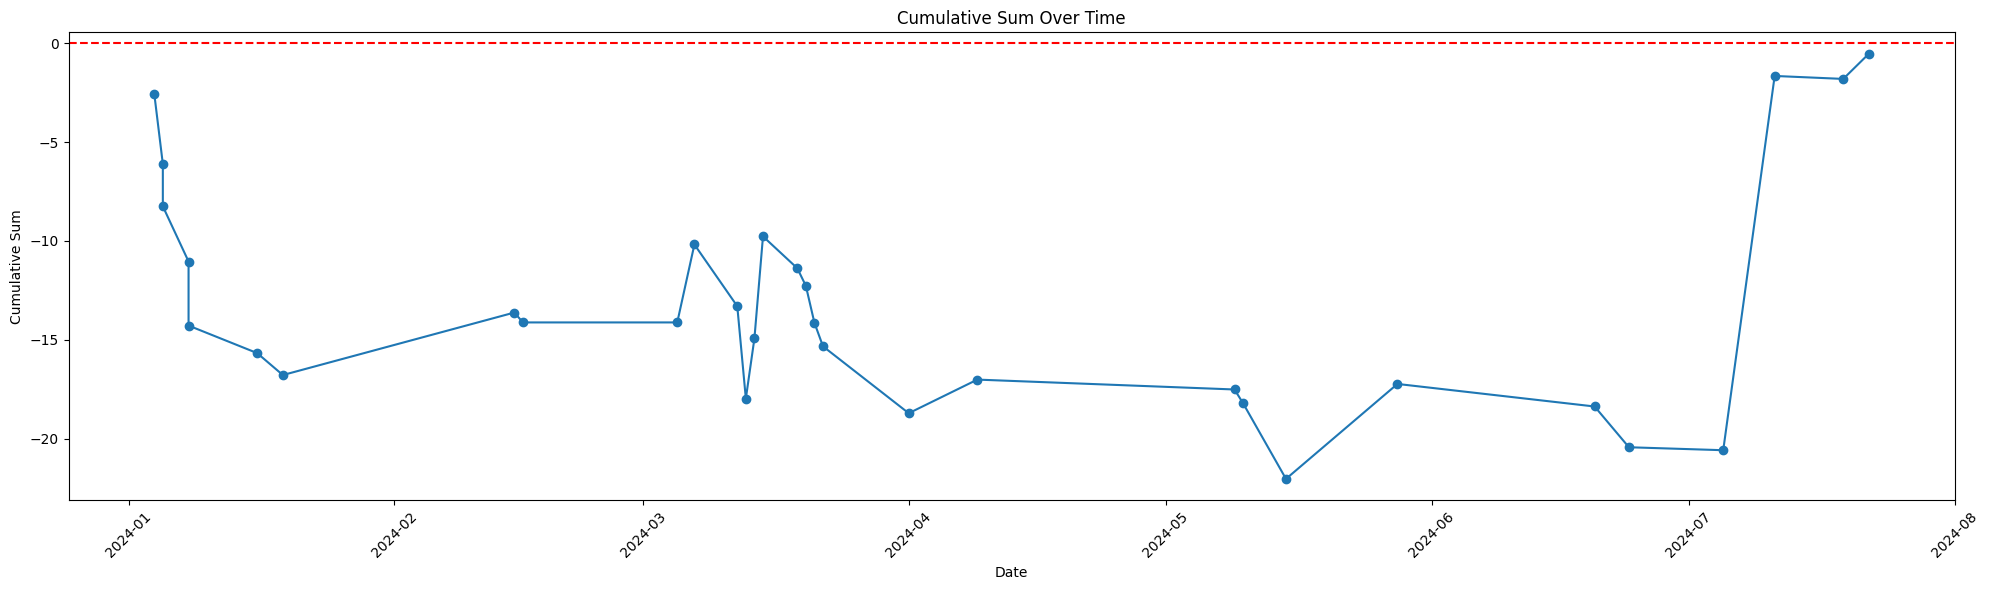

In [7]:
import matplotlib.pyplot as plt

# 假設 moving_list 是一個 dataframe
plt.figure(figsize=(20, 6))
plt.plot(moving_list['Date'], moving_list['cumsum'], marker='o')

# 加上 0 軸的水平線
plt.axhline(0, color='red', linestyle='--')

# 設定圖表標題和軸標籤
plt.title('Cumulative Sum Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum')

# 旋轉日期標籤避免重疊
plt.xticks(rotation=45)

# 顯示圖表
plt.tight_layout()
plt.show()


60RANK 240RANK 強勢 (因為已經走一段) 但平盤糾結 20RANK往下掉
5MA拉平
20MA上來
中間盤整可能抓20%吧

In [69]:
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
# 想想看要怎麼搞出 ㄏ 字形 參考寶碩 海報哥
df_unique0 = stock_df_raw[(stock_df_raw['Date']>='2023-01-01' ) & (stock_df_raw['Date']<='2023-12-31' ) & (stock_df_raw['20RS_rank'] < 20) & (stock_df_raw['60RS_rank'] > 60) & (stock_df_raw['240RS_rank'] > 80)]

#短側一個月效果不明顯  之後側一年看看
#df_unique0 = df_unique0.drop_duplicates(subset='證券代號', keep='first')

# 收盤在季線以上 年線以上 成值 1億 
df_unique0 = df_unique0[(df_unique0['收盤價']>df_unique0['60MA']) & 
                        (df_unique0['成交金額']>2000000) &
                        (df_unique0['成交股數']>1000000) ]

# df_unique = df_unique[(df_unique['收盤價']>df_unique['60MA']) & 
#                         (df_unique['收盤價']>df_unique['20MA']) &
#                         (df_unique['收盤價']>df_unique['5MA']) &
#                         (df_unique['成交金額']>50000000) &
#                         (df_unique['成交股數']>1500000) ]

#df_unique0[['Date','證券代號', '證券名稱', '20RS_rank', '60RS_rank', '240RS_rank']]

import numpy as np

# 計算各個移動平均線之間的相對差異
df_unique0['diff_10_20'] = np.abs(df_unique0['10MA'] - df_unique0['20MA']) / df_unique0['20MA']
df_unique0['diff_10_5'] = np.abs(df_unique0['10MA'] - df_unique0['5MA']) / df_unique0['5MA']
df_unique0['diff_20_5'] = np.abs(df_unique0['20MA'] - df_unique0['5MA']) / df_unique0['5MA']

# 檢查所有相對差異是否都在10%以內
df_unique0['is_within_10_percent'] = (df_unique0['diff_10_20'] <= 0.1) & (df_unique0['diff_10_5'] <= 0.1) & (df_unique0['diff_20_5'] <= 0.1)

# 篩選出符合條件的列
df_within_10_percent = df_unique0[df_unique0['is_within_10_percent']]

# 如果你只想保留這三個欄位而不要額外的計算欄位

df_within_10_percent


# stock_id_filter = df_unique0['證券代號'].unique().tolist()
# df_unique[df_unique['證券代號'].isin(stock_id_filter)]

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank,diff_10_20,diff_10_5,diff_20_5,is_within_10_percent
862789,2023-01-03,1584,精剛,3857597,1727,86070979,22.30,22.55,22.10,22.40,...,1.107508,90.598769,19.6535,113.9744,1.245063,88.640179,0.019608,0.012616,0.032869,True
862848,2023-01-03,1783,和康生,2262565,2322,104116128,47.20,47.20,45.50,45.50,...,1.062954,83.324007,42.2490,107.6950,1.176466,82.876329,0.022026,0.007566,0.014148,True
862862,2023-01-03,1810,和成,10813077,3757,200786143,18.45,18.85,18.25,18.60,...,1.184319,95.411304,13.7945,134.8368,1.472965,95.970901,0.053744,0.009444,0.046816,True
863036,2023-01-03,2444,兆勁,2601615,1283,42145073,16.55,16.75,15.85,16.60,...,1.145891,93.620593,12.8679,129.0030,1.409236,94.963626,0.015018,0.035859,0.020532,True
863135,2023-01-03,2707,晶華,2297808,3677,570360077,251.50,257.00,242.00,243.50,...,1.115823,91.606044,180.0313,135.2543,1.477525,96.082820,0.003825,0.004475,0.008268,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292417,2023-12-29,8068,全達,1415579,1128,56622124,41.10,41.35,39.40,39.70,...,1.016419,73.091708,30.9896,128.1076,1.170053,87.259747,0.033717,0.037366,0.003530,True
1292447,2023-12-29,8112,至上,9126245,5430,551091241,60.20,61.10,59.80,60.50,...,1.007987,69.082921,48.4015,124.9962,1.141636,85.172982,0.022333,0.013202,0.036347,True
1292500,2023-12-29,8426,紅木-KY,1462416,1276,113185852,79.80,80.60,74.30,74.30,...,1.079893,88.852279,54.0842,137.3785,1.254728,92.257002,0.043261,0.003306,0.044636,True
1292549,2023-12-29,8936,國統,9617807,4999,435942114,45.50,45.95,44.65,45.70,...,1.018542,73.915431,32.7138,139.6966,1.275900,93.574959,0.011221,0.024630,0.036258,True


In [49]:
# import pandas as pd
# import numpy as np

# # 假設 df 是你的股票數據 DataFrame，包含 'Date' 和 'Close' 列
# np.random.seed(42)

# df = pd.DataFrame({
#     'Date': pd.date_range(start='2023-01-01', periods=20, freq='D'),
#     'Close': np.random.randint(100, 200, 20)
# })


# df = stock_df_raw[(stock_df_raw['Date']>='2023-12-01' ) & (stock_df_raw['Date']<='2024-02-16' ) & (stock_df_raw['證券代號'] == '2353') ].copy()

# # 計算5日移動平均線
# # df['5_MA'] = df['Close'].rolling(window=5).mean()

# # 計算5日線的斜率
# # df['Slope5'] = df['5MA'].diff() / 1  # 1 表示天數變化量，即每個斜率都是與前一天相比計算
# # df['Slope20'] = df['20MA'].diff() / 1 # 1 表示天數變化量，即每個斜率都是與前一天相比計算

# # 顯示結果
# # 计算标准化斜率（以前一天的价格为基准）
# df['5MA_Slope'] = df['5MA'].diff() / df['5MA'].shift(1)
# df['20MA_Slope'] = df['20MA'].diff() / df['20MA'].shift(1)
# df['10MA_Slope'] = df['10MA'].diff() / df['10MA'].shift(1)
# # 将斜率转换为角度
# df['Slope_Angle5'] = np.degrees(np.arctan(df['5MA_Slope']))
# df['Slope_Angle10'] = np.degrees(np.arctan(df['10MA_Slope']))
# df['Slope_Angle20'] = np.degrees(np.arctan(df['20MA_Slope']))
# df[['Date','證券名稱', '收盤價','5MA','10MA','20MA','Slope_Angle5','Slope_Angle10','Slope_Angle20']].dropna().head()

# #df_within_10_percent['20MA_Slope'] =  df_within_10_percent['20MA'].diff() / 1

In [70]:

filter_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])

# 盤整時間
relax_day = 10
up_day = 30
stock_id_filter = []
collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', 'Date', 'relax_day_max', 'relax_day_min', 'slope20_count','slope5_count'])

for i in range(len(df_within_10_percent)):
        temp_df = df_within_10_percent.iloc[i].copy()

        # 均線糾結那天 
        filter_day = pd.to_datetime(temp_df['Date'])
        # STOCK ID
        filter_stock_id = temp_df['證券代號']

        # ㄏ字形中間盤整區間 高低差不要大於20% max_min_diff < 0.2
        temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] < filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] != 0) ].copy()
        # 一年內高低點
        temp_df_his.loc[:, 'relax_day_min'] = temp_df_his['收盤價'].rolling(relax_day).min()
        temp_df_his.loc[:, 'relax_day_max'] = temp_df_his['收盤價'].rolling(up_day).max()  # 最大值看ㄏ的頭 看長一點

        relax_day_min = temp_df_his.tail(1)['relax_day_min'].iloc[0]
        relax_day_max = temp_df_his.tail(1)['relax_day_max'].iloc[0]

        if (relax_day_min == 0) |  (relax_day_max == 0) :
                print('relax_day = 0 stock_name:' + temp_df['證券名稱'].iloc[0] + "today_str" + filter_day + "stock_id" + filter_stock_id)
        else:
                max_min_diff = abs(relax_day_min - relax_day_max) / relax_day_min 


        # 計算20日線斜率  ㄏ   
        temp_his_tail20 = temp_df_his.tail(relax_day).copy()
        temp_his_tail20['20MA_Slope'] = temp_his_tail20['20MA'].diff() / temp_his_tail20['20MA'].shift(1)
        # 将斜率转换为角度
        temp_his_tail20['Slope_Angle20'] = np.degrees(np.arctan(temp_his_tail20['20MA_Slope']))
        # 第一天不會有斜率
        temp_his_tail20 = temp_his_tail20.dropna()


        # 計算5日線斜率  ㄏ   
        temp_his_tail5 = temp_df_his.tail(up_day).copy()
        temp_his_tail5['5MA_Slope'] = temp_his_tail5['5MA'].diff() / temp_his_tail5['5MA'].shift(1)
        temp_his_tail5['Slope_Angle5'] = np.degrees(np.arctan(temp_his_tail5['5MA_Slope']))
        # 第一天不會有斜率
        temp_his_tail5 = temp_his_tail5.dropna()


        slope20_count = len(temp_his_tail20[temp_his_tail20['Slope_Angle20'] < 0])
        slope5_count = len(temp_his_tail5[temp_his_tail5['Slope_Angle5'] > 2])  # 看起來大於1就會開始很斜了

        if( (slope20_count == 0) & (slope5_count > 2) & (max_min_diff < 0.35) &  (temp_df['收盤價'] * 1.2 > relax_day_max) ):
                result_df = pd.DataFrame({
                '證券代號': [ filter_stock_id],
                '證券名稱': [temp_df['證券名稱']],
                '收盤價': [temp_df['收盤價']],
                'Date': [temp_df['Date']],
                'relax_day_max': [relax_day_max],
                'relax_day_min': [relax_day_min],
                'slope20_count': [slope20_count],
                'slope5_count': [slope5_count]
                })
                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        collected_data = pd.concat([collected_data, result_df], ignore_index=True)

                # stock_id_filter.append(filter_stock_id) 


# filter_stock = df_within_10_percent[df_within_10_percent['證券代號'].isin(stock_id_filter)]

# filter_stock = filter_stock[['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價']]

# filter_stock

collected_data

filter_stock_uni = collected_data.drop_duplicates(subset='證券代號', keep='last')
filter_stock_uni
#filter_stock_uni[filter_stock_uni['證券代號'] == '2359']

,證券代號,證券名稱,收盤價,Date,relax_day_max,relax_day_min,slope20_count,slope5_count
3,1342,八貫,120.50,2023-01-05,141.00,119.00,0,6
5,4114,健喬,44.75,2023-01-05,53.00,45.60,0,5
10,2444,兆勁,17.75,2023-01-09,20.90,16.55,0,4
12,1720,生達,55.90,2023-01-10,65.00,57.20,0,3
19,2929,淘帝-KY,16.35,2023-01-12,18.15,16.60,0,5
...,...,...,...,...,...,...,...,...
377,1591,駿吉-KY,51.50,2023-12-29,59.90,51.10,0,6
378,3287,廣寰科,33.00,2023-12-29,39.45,34.60,0,7
379,4909,新復興,31.85,2023-12-29,35.00,32.80,0,4
380,6462,神盾,119.50,2023-12-29,135.50,121.50,0,4


In [71]:
# 往後篩 突破前高追 
collected_data2 = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])
# 盤整時間
relax_day = 20
stock_id_filter = []

for i in range(len(filter_stock_uni)):
        temp_df = filter_stock_uni.iloc[i].copy()

        # 篩出結果那天
        filter_day = pd.to_datetime(temp_df['Date'])

        # 突破前高需在六個月內
        filter_day2 = filter_day + timedelta(days=180)

        # STOCK ID
        filter_stock_id = temp_df['證券代號']
        # 前高 
        before_max = temp_df['relax_day_max']
        

        # 名單開始往後看 哪天突破前高
        temp_df_after = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['Date'] < filter_day2.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] > before_max) & (stock_df_raw['60RS_rank'] > 80)].copy()

        temp_df_after_1 = temp_df_after.head(1)

        if not temp_df_after_1.empty:
                collected_data2 = pd.concat([collected_data2, temp_df_after_1], ignore_index=True)




In [68]:
# tt = collected_data2[['Date','證券代號', '證券名稱', '20RS_rank', '60RS_rank', '240RS_rank']]
# tt = tt.sort_values(by='Date')
# tt

In [76]:
import warnings
# 計算出場  使用60RS看看
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

RS_down = list(range(65, 80, 1))

profolio_df1 = pd.DataFrame(columns=['rs_value', 'mean', 'mean_t1', 'mean_t2','hold_day_mean1','hold_day_mean2'])

for rs_value in RS_down:
    collected_data = pd.DataFrame(columns=['rs_value','stock_id', 'stock_name', 'Date', '收盤價', '隔天收盤價', '收盤價_RS小於75','隔天開盤_RS小於75', '收盤價_dff','隔日開盤價_dff','收盤價_隔天收盤_dff','收盤價_隔天開盤_dff','持有天數1','持有天數2'])
    
    for i in range(len(collected_data2)):
        temp_df = collected_data2.iloc[i].copy()

        filter_day = pd.to_datetime(temp_df['Date'])
        # filter_day30 = filter_day + pd.Timedelta(days=hold_day)
        filter_stock_id = temp_df['證券代號']


        # 篩到之後 隔天一開盤要買 (回測起來 隔天收盤買效果好像更好ㄟ)

        tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['收盤價'].iloc[0]
        # tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]

        # 找到跌落RS後 不可能那天開盤價可以賣 要重測一次
        RS75_df_t = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['20RS_rank'] < rs_value)].copy()
        getout_day = RS75_df_t['Date'].iloc[0]
        RS75_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > getout_day.strftime('%Y-%m-%d'))].copy()

        

        if RS75_df.empty:
            continue

        stock_df_RS750 = RS75_df.iloc[0] # 符合條件當天收盤賣
        stock_df_RS751 = RS75_df.iloc[1] # 符合條件隔天開盤再賣

        diff_day1 = (stock_df_RS750['Date'] - temp_df['Date']).days

        diff1 = round(100 * (stock_df_RS750['收盤價'] / temp_df['收盤價'] - 1), 2) #撈出來當天
        diff_t1 = round(100 * (stock_df_RS750['收盤價'] / tomorrow_open - 1), 2)  #撈出來隔天

        diff_day2 = (stock_df_RS751['Date'] - temp_df['Date']).days

        diff2 = round(100 * (stock_df_RS751['開盤價'] / temp_df['收盤價'] - 1), 2)
        diff_t2 = round(100 * (stock_df_RS751['開盤價'] / tomorrow_open - 1), 2)


        result_df = pd.DataFrame({
            'rs_value': [rs_value],
            'stock_id': [filter_stock_id],
            'stock_name': [temp_df['證券名稱']],
            'Date': [temp_df['Date']],
            '收盤價': [temp_df['收盤價']],
            '隔天收盤價': [tomorrow_open],
            '收盤價_RS小於75': [stock_df_RS750['收盤價']],
            '隔天開盤_RS小於75': [stock_df_RS751['收盤價']],
            '收盤價_dff': [diff1],
            '隔日開盤價_dff': [diff2],
            '收盤價_隔天收盤_dff': [diff_t1],
            '收盤價_隔天開盤_dff': [diff_t2],
            '持有天數1': [diff_day1],
            '持有天數2': [diff_day2]
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)

        if not result_df.empty:
            collected_data = pd.concat([collected_data, result_df], ignore_index=True)

    # 仅当collected_data不为空时，计算mean并合并到profolio_df中
    if not collected_data.empty:
        mean = collected_data['收盤價_dff'].mean()
        mean_t1 = collected_data['收盤價_隔天收盤_dff'].mean()
        mean_t2 = collected_data['收盤價_隔天開盤_dff'].mean()
        hold_day_mean1 = collected_data['持有天數1'].mean()
        hold_day_mean2 = collected_data['持有天數2'].mean()
        profolio_data = pd.DataFrame({
            'rs_value': [rs_value],
            'mean': [mean],
            'mean_t1': [mean_t1],
            'mean_t2': [mean_t2],
            'hold_day_mean1' : [hold_day_mean1],
            'hold_day_mean2' : [hold_day_mean2],
        })
        profolio_df1 = pd.concat([profolio_df1, profolio_data], ignore_index=True)
        
profolio_df1['pen1'] = profolio_df1['mean']/ profolio_df1['hold_day_mean1']
profolio_df1['pen_t1'] = profolio_df1['mean_t1']/ profolio_df1['hold_day_mean1']

profolio_df1['pen2'] = profolio_df1['mean']/ profolio_df1['hold_day_mean2']
profolio_df1['pen_t2'] = profolio_df1['mean_t2']/ profolio_df1['hold_day_mean2']

profolio_df1['diff_pen1'] = profolio_df1['mean_t1'] - profolio_df1['mean']
profolio_df1['diff_pen2'] = profolio_df1['mean_t2'] - profolio_df1['mean']

print('======profolio_df1======diff_pen=================')
print(profolio_df1['diff_pen1'].mean())
print(profolio_df1['diff_pen2'].mean())
profolio_df1


======profolio_df1======diff_pen=================
-1.3900406504065044
-0.7534227642276422


,rs_value,mean,mean_t1,mean_t2,hold_day_mean1,hold_day_mean2,pen1,pen_t1,pen2,pen_t2,diff_pen1,diff_pen2
0,65,3.960122,2.622927,3.291220,21.536585,23.170732,0.183879,0.121789,0.170911,0.142042,-1.337195,-0.668902
1,66,4.276341,2.956707,3.664146,21.036585,22.731707,0.203281,0.140551,0.188122,0.161191,-1.319634,-0.612195
2,67,3.303780,1.917317,2.548415,20.109756,21.853659,0.164287,0.095343,0.151177,0.116613,-1.386463,-0.755366
3,68,3.280000,1.895976,2.511341,19.841463,21.609756,0.165310,0.095556,0.151783,0.116213,-1.384024,-0.768659
4,69,3.252927,1.867805,2.471585,19.792683,21.585366,0.164350,0.094368,0.150701,0.114503,-1.385122,-0.781341
5,70,3.317317,1.931220,2.500976,19.597561,21.390244,0.169272,0.098544,0.155086,0.116921,-1.386098,-0.816341
6,71,3.531951,2.151098,2.727317,19.402439,21.219512,0.182036,0.110867,0.166448,0.128529,-1.380854,-0.804634
7,72,3.647317,2.254512,2.843659,18.695122,20.487805,0.195095,0.120594,0.178024,0.138798,-1.392805,-0.803659
8,73,3.672927,2.275488,2.847073,18.597561,20.365854,0.197495,0.122354,0.180347,0.139796,-1.397439,-0.825854
9,74,3.522073,2.134146,2.733293,18.500000,20.268293,0.190382,0.115359,0.173773,0.134856,-1.387927,-0.788780


In [74]:
profolio_df1

,rs_value,mean,mean_t1,mean_t2,hold_day_mean1,hold_day_mean2,pen1,pen_t1,pen2,pen_t2,diff_pen1,diff_pen2
0,65,5.058659,3.679756,4.222683,50.853659,52.463415,0.099475,0.072360,0.096423,0.080488,-1.378902,-0.835976
1,66,5.410366,4.045976,4.635366,50.024390,51.682927,0.108155,0.080880,0.104684,0.089689,-1.364390,-0.775000
2,67,5.636098,4.272683,4.878780,49.536585,51.268293,0.113776,0.086253,0.109933,0.095162,-1.363415,-0.757317
3,68,5.831098,4.476829,5.086463,49.085366,50.743902,0.118795,0.091205,0.114912,0.100238,-1.354268,-0.744634
4,69,5.719024,4.331463,4.981951,47.731707,49.353659,0.119816,0.090746,0.115878,0.100944,-1.387561,-0.737073
5,70,5.852439,4.456585,5.054756,46.987805,48.585366,0.124552,0.094846,0.120457,0.104039,-1.395854,-0.797683
6,71,5.914878,4.524634,5.178171,46.414634,47.987805,0.127436,0.097483,0.123258,0.107906,-1.390244,-0.736707
7,72,6.232439,4.846098,5.350976,45.060976,46.548780,0.138311,0.107545,0.133890,0.114954,-1.386341,-0.881463
8,73,6.544268,5.153293,5.736463,44.658537,46.097561,0.146540,0.115393,0.141966,0.124442,-1.390976,-0.807805
9,74,6.443902,5.060976,5.642683,44.060976,45.451220,0.146250,0.114863,0.141776,0.124148,-1.382927,-0.801220


In [75]:
# collected_data.sort_values(by='收盤價_dff')

In [210]:
df_within_10_percent[df_within_10_percent['證券代號'] == '2359']

# ㄏ字形中間盤整區間 高低差不要大於20% max_min_diff < 0.2
temp_df_his = stock_df_raw[(stock_df_raw['證券代號']=='2359') & (stock_df_raw['Date'] < '2024-05-06') & (stock_df_raw['收盤價'] != 0) ].copy()
# 一年內高低點
temp_df_his.loc[:, 'relax_day_min'] = temp_df_his['收盤價'].rolling(relax_day).min()
temp_df_his.loc[:, 'relax_day_max'] = temp_df_his['收盤價'].rolling(relax_day).max()

relax_day_min = temp_df_his.tail(1)['relax_day_min'].iloc[0]
relax_day_max = temp_df_his.tail(1)['relax_day_max'].iloc[0]

if (relax_day_min == 0) |  (relax_day_max == 0) :
        print('relax_day = 0 stock_name:' + temp_df['證券名稱'].iloc[0] + "today_str" + filter_day + "stock_id" + filter_stock_id)
else:
        max_min_diff = abs(relax_day_min - relax_day_max) / relax_day_min 


# 計算20日線斜率  ㄏ   
temp_his_tail20 = temp_df_his.tail(relax_day).copy()
temp_his_tail20['20MA_Slope'] = temp_his_tail20['20MA'].diff() / temp_his_tail20['20MA'].shift(1)
# 将斜率转换为角度
temp_his_tail20['Slope_Angle20'] = np.degrees(np.arctan(temp_his_tail20['20MA_Slope']))
# 第一天不會有斜率
temp_his_tail20 = temp_his_tail20.dropna()


# 計算5日線斜率  ㄏ   
temp_his_tail5 = temp_df_his.tail(up_day).copy()
temp_his_tail5['5MA_Slope'] = temp_his_tail5['5MA'].diff() / temp_his_tail5['5MA'].shift(1)
temp_his_tail5['Slope_Angle5'] = np.degrees(np.arctan(temp_his_tail5['5MA_Slope']))
# 第一天不會有斜率
temp_his_tail5 = temp_his_tail5.dropna()


slope20_count = len(temp_his_tail20[temp_his_tail20['Slope_Angle20'] < 0])
slope5_count = len(temp_his_tail5[temp_his_tail5['Slope_Angle5'] > 2.5])

print(slope20_count)
print(slope5_count)

0
11


In [205]:
max_min_diff

0.3276492082825823

In [ ]:

# 
filter_stock_list2 = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])

# 盤整時間
relax_day = 20
stock_id_filter = []

for i in range(len(filter_stock_uni)):
        temp_df = filter_stock_uni.iloc[i].copy()

        # 均線糾結那天 
        filter_day = pd.to_datetime(temp_df['Date'])
        # STOCK ID
        filter_stock_id = temp_df['證券代號']

        # ㄏ字形中間盤整區間 高低差不要大於20% max_min_diff < 0.2
        temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==filter_stock_id) & (stock_df_raw['Date'] < filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['收盤價'] != 0) ].copy()
        # 一年內高低點
        temp_df_his.loc[:, 'relax_day_min'] = temp_df_his['收盤價'].rolling(relax_day).min()
        temp_df_his.loc[:, 'relax_day_max'] = temp_df_his['收盤價'].rolling(relax_day).max()

        relax_day_min = temp_df_his.tail(1)['relax_day_min'].iloc[0]
        relax_day_max = temp_df_his.tail(1)['relax_day_max'].iloc[0]

        if (relax_day_min == 0) |  (relax_day_max == 0) :
                print('relax_day = 0 stock_name:' + temp_df['證券名稱'].iloc[0] + "today_str" + filter_day + "stock_id" + filter_stock_id)
        else:
                max_min_diff = abs(relax_day_min - relax_day_max) / relax_day_min 


        # 計算斜率        
        temp_his_tail = temp_df_his.tail(relax_day).copy()

        temp_his_tail['20MA_Slope'] =  temp_his_tail['20MA'].diff() / 1
        temp_his_tail['5MA_Slope'] =  temp_his_tail['5MA'].diff() / 1

        slope20_count = len(temp_his_tail[temp_his_tail['20MA_Slope'] < 0])
        slope5_count = len(temp_his_tail[temp_his_tail['5MA_Slope'] < -2])

        if( (slope20_count == 0) & (slope5_count == 0) & (max_min_diff < 0.2) & (temp_df['收盤價'] > temp_df['8MA']) &  (temp_df['收盤價'] * 1.2 > relax_day_max) ):
                stock_id_filter.append(filter_stock_id) 


filter_stock = df_within_10_percent[df_within_10_percent['證券代號'].isin(stock_id_filter)]

filter_stock = filter_stock[['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價']]

filter_stock


In [ ]:
# 研究可以達到 RANK 100的股票之前共通點

import numpy as np
import warnings
# 計算出場  使用60RS看看
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

RS_down = ['5MA','8MA','10MA','20MA','60MA']

profolio_df1 = pd.DataFrame(columns=['rs_value', 'mean', 'mean_t1', 'mean_t2','hold_day_mean1','hold_day_mean2'])

for rs_value in RS_down:
    collected_data = pd.DataFrame(columns=['rs_value','stock_id', 'stock_name', 'Date', '收盤價', '隔天收盤價', '收盤價_RS小於75','隔天開盤_RS小於75', '收盤價_dff','隔日開盤價_dff','收盤價_隔天收盤_dff','收盤價_隔天開盤_dff','持有天數1','持有天數2'])
    
    for i in range(len(df_unique)):
        temp_df = df_unique.iloc[i].copy()

        # 達到 RANK 100 那天
        filter_day = pd.to_datetime(temp_df['Date'])
        # filter_day30 = filter_day + pd.Timedelta(days=hold_day)
        filter_stock_id = temp_df['證券代號']


        # 篩到之後 隔天一開盤要買 (回測起來 隔天收盤買效果好像更好ㄟ)

        tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]
        # tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]

        # 找到跌落RS後 不可能那天開盤價可以賣 要重測一次
        Rank100before = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] < filter_day.strftime('%Y-%m-%d')) ].copy()


        RS75_df_t = RS75_df_t[RS75_df_t[rs_value] > RS75_df_t['收盤價']]

        getout_day = RS75_df_t['Date'].iloc[0]
        RS75_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > getout_day.strftime('%Y-%m-%d'))].copy()

        

        if RS75_df.empty:
            continue

        stock_df_RS750 = RS75_df.iloc[0] # 符合條件當天收盤賣
        stock_df_RS751 = RS75_df.iloc[1] # 符合條件隔天開盤再賣

        diff_day1 = (stock_df_RS750['Date'] - temp_df['Date']).days

        diff1 = round(100 * (stock_df_RS750['收盤價'] / temp_df['收盤價'] - 1), 2) #撈出來當天
        diff_t1 = round(100 * (stock_df_RS750['收盤價'] / tomorrow_open - 1), 2)  #撈出來隔天

        diff_day2 = (stock_df_RS751['Date'] - temp_df['Date']).days

        diff2 = round(100 * (stock_df_RS751['開盤價'] / temp_df['收盤價'] - 1), 2)
        diff_t2 = round(100 * (stock_df_RS751['開盤價'] / tomorrow_open - 1), 2)


        result_df = pd.DataFrame({
            'rs_value': [rs_value],
            'stock_id': [filter_stock_id],
            'stock_name': [temp_df['證券名稱']],
            'Date': [temp_df['Date']],
            '收盤價': [temp_df['收盤價']],
            '隔天收盤價': [tomorrow_open],
            '收盤價_RS小於75': [stock_df_RS750['收盤價']],
            '隔天開盤_RS小於75': [stock_df_RS751['收盤價']],
            '收盤價_dff': [diff1],
            '隔日開盤價_dff': [diff2],
            '收盤價_隔天收盤_dff': [diff_t1],
            '收盤價_隔天開盤_dff': [diff_t2],
            '持有天數1': [diff_day1],
            '持有天數2': [diff_day2]
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)

        if not result_df.empty:
            collected_data = pd.concat([collected_data, result_df], ignore_index=True)

    # 仅当collected_data不为空时，计算mean并合并到profolio_df中
    if not collected_data.empty:
        mean = collected_data['收盤價_dff'].mean()
        mean_t1 = collected_data['收盤價_隔天收盤_dff'].mean()
        mean_t2 = collected_data['收盤價_隔天開盤_dff'].mean()
        hold_day_mean1 = collected_data['持有天數1'].mean()
        hold_day_mean2 = collected_data['持有天數2'].mean()
        profolio_data = pd.DataFrame({
            'rs_value': [rs_value],
            'mean': [mean],
            'mean_t1': [mean_t1],
            'mean_t2': [mean_t2],
            'hold_day_mean1' : [hold_day_mean1],
            'hold_day_mean2' : [hold_day_mean2],
        })
        profolio_df1 = pd.concat([profolio_df1, profolio_data], ignore_index=True)
        
profolio_df1['pen1'] = profolio_df1['mean']/ profolio_df1['hold_day_mean1']
profolio_df1['pen_t1'] = profolio_df1['mean_t1']/ profolio_df1['hold_day_mean1']

profolio_df1['pen2'] = profolio_df1['mean']/ profolio_df1['hold_day_mean2']
profolio_df1['pen_t2'] = profolio_df1['mean_t2']/ profolio_df1['hold_day_mean2']

profolio_df1['diff_pen1'] = profolio_df1['mean_t1'] - profolio_df1['mean']
profolio_df1['diff_pen2'] = profolio_df1['mean_t2'] - profolio_df1['mean']

print('======profolio_df1======diff_pen=================')
print(profolio_df1['diff_pen1'].mean())
print(profolio_df1['diff_pen2'].mean())
profolio_df1


In [71]:
# 直接回測起來

import numpy as np
import warnings
# 計算出場  使用60RS看看
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

RS_down = ['5MA','8MA','10MA','20MA','60MA']

profolio_df1 = pd.DataFrame(columns=['rs_value', 'mean', 'mean_t1', 'mean_t2','hold_day_mean1','hold_day_mean2'])

for rs_value in RS_down:
    collected_data = pd.DataFrame(columns=['rs_value','stock_id', 'stock_name', 'Date', '收盤價', '隔天收盤價', '收盤價_RS小於75','隔天開盤_RS小於75', '收盤價_dff','隔日開盤價_dff','收盤價_隔天收盤_dff','收盤價_隔天開盤_dff','持有天數1','持有天數2'])
    
    for i in range(len(df_unique)):
        temp_df = df_unique.iloc[i].copy()

        filter_day = pd.to_datetime(temp_df['Date'])
        # filter_day30 = filter_day + pd.Timedelta(days=hold_day)
        filter_stock_id = temp_df['證券代號']


        # 篩到之後 隔天一開盤要買 (回測起來 隔天收盤買效果好像更好ㄟ)

        tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]
        # tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]

        # 找到跌落RS後 不可能那天開盤價可以賣 要重測一次
        RS75_df_t = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) ].copy()
        RS75_df_t = RS75_df_t[RS75_df_t[rs_value] > RS75_df_t['收盤價']]

        getout_day = RS75_df_t['Date'].iloc[0]
        RS75_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > getout_day.strftime('%Y-%m-%d'))].copy()

        

        if RS75_df.empty:
            continue

        stock_df_RS750 = RS75_df.iloc[0] # 符合條件當天收盤賣
        stock_df_RS751 = RS75_df.iloc[1] # 符合條件隔天開盤再賣

        diff_day1 = (stock_df_RS750['Date'] - temp_df['Date']).days

        diff1 = round(100 * (stock_df_RS750['收盤價'] / temp_df['收盤價'] - 1), 2) #撈出來當天
        diff_t1 = round(100 * (stock_df_RS750['收盤價'] / tomorrow_open - 1), 2)  #撈出來隔天

        diff_day2 = (stock_df_RS751['Date'] - temp_df['Date']).days

        diff2 = round(100 * (stock_df_RS751['開盤價'] / temp_df['收盤價'] - 1), 2)
        diff_t2 = round(100 * (stock_df_RS751['開盤價'] / tomorrow_open - 1), 2)


        result_df = pd.DataFrame({
            'rs_value': [rs_value],
            'stock_id': [filter_stock_id],
            'stock_name': [temp_df['證券名稱']],
            'Date': [temp_df['Date']],
            '收盤價': [temp_df['收盤價']],
            '隔天收盤價': [tomorrow_open],
            '收盤價_RS小於75': [stock_df_RS750['收盤價']],
            '隔天開盤_RS小於75': [stock_df_RS751['收盤價']],
            '收盤價_dff': [diff1],
            '隔日開盤價_dff': [diff2],
            '收盤價_隔天收盤_dff': [diff_t1],
            '收盤價_隔天開盤_dff': [diff_t2],
            '持有天數1': [diff_day1],
            '持有天數2': [diff_day2]
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)

        if not result_df.empty:
            collected_data = pd.concat([collected_data, result_df], ignore_index=True)

    # 仅当collected_data不为空时，计算mean并合并到profolio_df中
    if not collected_data.empty:
        mean = collected_data['收盤價_dff'].mean()
        mean_t1 = collected_data['收盤價_隔天收盤_dff'].mean()
        mean_t2 = collected_data['收盤價_隔天開盤_dff'].mean()
        hold_day_mean1 = collected_data['持有天數1'].mean()
        hold_day_mean2 = collected_data['持有天數2'].mean()
        profolio_data = pd.DataFrame({
            'rs_value': [rs_value],
            'mean': [mean],
            'mean_t1': [mean_t1],
            'mean_t2': [mean_t2],
            'hold_day_mean1' : [hold_day_mean1],
            'hold_day_mean2' : [hold_day_mean2],
        })
        profolio_df1 = pd.concat([profolio_df1, profolio_data], ignore_index=True)
        
profolio_df1['pen1'] = profolio_df1['mean']/ profolio_df1['hold_day_mean1']
profolio_df1['pen_t1'] = profolio_df1['mean_t1']/ profolio_df1['hold_day_mean1']

profolio_df1['pen2'] = profolio_df1['mean']/ profolio_df1['hold_day_mean2']
profolio_df1['pen_t2'] = profolio_df1['mean_t2']/ profolio_df1['hold_day_mean2']

profolio_df1['diff_pen1'] = profolio_df1['mean_t1'] - profolio_df1['mean']
profolio_df1['diff_pen2'] = profolio_df1['mean_t2'] - profolio_df1['mean']

print('======profolio_df1======diff_pen=================')
print(profolio_df1['diff_pen1'].mean())
print(profolio_df1['diff_pen2'].mean())
profolio_df1


======profolio_df1======diff_pen=================
-0.9808800000000006
-0.8555200000000003


,rs_value,mean,mean_t1,mean_t2,hold_day_mean1,hold_day_mean2,pen1,pen_t1,pen2,pen_t2,diff_pen1,diff_pen2
0,5MA,-2.4224,-3.3532,-3.1764,6.28,7.64,-0.385732,-0.533949,-0.317068,-0.415759,-0.9308,-0.7540
1,8MA,-1.1124,-2.1160,-2.2472,10.32,11.64,-0.107791,-0.205039,-0.095567,-0.193058,-1.0036,-1.1348
2,10MA,-2.6868,-3.6740,-3.8508,11.64,12.76,-0.230825,-0.315636,-0.210564,-0.301787,-0.9872,-1.1640
3,20MA,-0.4576,-1.4556,-1.0540,23.76,25.28,-0.019259,-0.061263,-0.018101,-0.041693,-0.9980,-0.5964
4,60MA,-7.0748,-8.0596,-7.7032,59.16,60.68,-0.119588,-0.136234,-0.116592,-0.126948,-0.9848,-0.6284


可能可以拿來當 做空的標的 但可能需要找融券 而且%數也不高 需要再優化

In [74]:
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
RANK240_list = stock_df_raw[(stock_df_raw['Date']>='2023-01-01' ) & (stock_df_raw['Date']<'2023-12-31' ) & (stock_df_raw['60RS_rank'] == 100)]

#短側一個月效果不明顯  之後側一年看看
df_unique = RANK240_list.drop_duplicates(subset='證券代號', keep='first')

# 收盤在季線以上 年線以上 成值 1億 
df_unique = df_unique[(df_unique['收盤價']>df_unique['60MA']) & 
                        (df_unique['成交金額']>100000000) &
                        (df_unique['成交股數']>2000000) ]
df_unique[['Date','證券代號', '證券名稱', '20RS_rank', '60RS_rank', '240RS_rank']]

In [75]:
# 直接回測起來
import numpy as np
import warnings
# 計算出場  使用60RS看看
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

RS_down = list(np.arange(95, 100, 0.5))

profolio_df1 = pd.DataFrame(columns=['rs_value', 'mean', 'mean_t1', 'mean_t2','hold_day_mean1','hold_day_mean2'])

for rs_value in RS_down:
    collected_data = pd.DataFrame(columns=['rs_value','stock_id', 'stock_name', 'Date', '收盤價', '隔天收盤價', '收盤價_RS小於75','隔天開盤_RS小於75', '收盤價_dff','隔日開盤價_dff','收盤價_隔天收盤_dff','收盤價_隔天開盤_dff','持有天數1','持有天數2'])
    
    for i in range(len(df_unique)):
        temp_df = df_unique.iloc[i].copy()

        filter_day = pd.to_datetime(temp_df['Date'])
        # filter_day30 = filter_day + pd.Timedelta(days=hold_day)
        filter_stock_id = temp_df['證券代號']


        # 篩到之後 隔天一開盤要買 (回測起來 隔天收盤買效果好像更好ㄟ)

        tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['收盤價'].iloc[0]
        # tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]

        # 找到跌落RS後 不可能那天開盤價可以賣 要重測一次
        RS75_df_t = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['60RS_rank'] < rs_value)].copy()
        getout_day = RS75_df_t['Date'].iloc[0]
        RS75_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > getout_day.strftime('%Y-%m-%d'))].copy()

        

        if RS75_df.empty:
            continue

        stock_df_RS750 = RS75_df.iloc[0] # 符合條件當天收盤賣
        stock_df_RS751 = RS75_df.iloc[1] # 符合條件隔天開盤再賣

        diff_day1 = (stock_df_RS750['Date'] - temp_df['Date']).days

        diff1 = round(100 * (stock_df_RS750['收盤價'] / temp_df['收盤價'] - 1), 2) #撈出來當天
        diff_t1 = round(100 * (stock_df_RS750['收盤價'] / tomorrow_open - 1), 2)  #撈出來隔天

        diff_day2 = (stock_df_RS751['Date'] - temp_df['Date']).days

        diff2 = round(100 * (stock_df_RS751['開盤價'] / temp_df['收盤價'] - 1), 2)
        diff_t2 = round(100 * (stock_df_RS751['開盤價'] / tomorrow_open - 1), 2)


        result_df = pd.DataFrame({
            'rs_value': [rs_value],
            'stock_id': [filter_stock_id],
            'stock_name': [temp_df['證券名稱']],
            'Date': [temp_df['Date']],
            '收盤價': [temp_df['收盤價']],
            '隔天收盤價': [tomorrow_open],
            '收盤價_RS小於75': [stock_df_RS750['收盤價']],
            '隔天開盤_RS小於75': [stock_df_RS751['收盤價']],
            '收盤價_dff': [diff1],
            '隔日開盤價_dff': [diff2],
            '收盤價_隔天收盤_dff': [diff_t1],
            '收盤價_隔天開盤_dff': [diff_t2],
            '持有天數1': [diff_day1],
            '持有天數2': [diff_day2]
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)

        if not result_df.empty:
            collected_data = pd.concat([collected_data, result_df], ignore_index=True)

    # 仅当collected_data不为空时，计算mean并合并到profolio_df中
    if not collected_data.empty:
        mean = collected_data['收盤價_dff'].mean()
        mean_t1 = collected_data['收盤價_隔天收盤_dff'].mean()
        mean_t2 = collected_data['收盤價_隔天開盤_dff'].mean()
        hold_day_mean1 = collected_data['持有天數1'].mean()
        hold_day_mean2 = collected_data['持有天數2'].mean()
        profolio_data = pd.DataFrame({
            'rs_value': [rs_value],
            'mean': [mean],
            'mean_t1': [mean_t1],
            'mean_t2': [mean_t2],
            'hold_day_mean1' : [hold_day_mean1],
            'hold_day_mean2' : [hold_day_mean2],
        })
        profolio_df1 = pd.concat([profolio_df1, profolio_data], ignore_index=True)
        
profolio_df1['pen1'] = profolio_df1['mean']/ profolio_df1['hold_day_mean1']
profolio_df1['pen_t1'] = profolio_df1['mean_t1']/ profolio_df1['hold_day_mean1']

profolio_df1['pen2'] = profolio_df1['mean']/ profolio_df1['hold_day_mean2']
profolio_df1['pen_t2'] = profolio_df1['mean_t2']/ profolio_df1['hold_day_mean2']

profolio_df1['diff_pen1'] = profolio_df1['mean_t1'] - profolio_df1['mean']
profolio_df1['diff_pen2'] = profolio_df1['mean_t2'] - profolio_df1['mean']

print('======profolio_df1======diff_pen=================')
print(profolio_df1['diff_pen1'].mean())
print(profolio_df1['diff_pen2'].mean())
profolio_df1


======profolio_df1======diff_pen=================
3.043375
3.1505000000000005


,rs_value,mean,mean_t1,mean_t2,hold_day_mean1,hold_day_mean2,pen1,pen_t1,pen2,pen_t2,diff_pen1,diff_pen2
0,95.0,-6.60250,-3.71000,-4.16000,41.500,43.000,-0.159096,-0.089398,-0.153547,-0.096744,2.89250,2.44250
1,95.5,-6.47500,-3.56750,-3.63500,40.375,41.875,-0.160372,-0.088359,-0.154627,-0.086806,2.90750,2.84000
2,96.0,-3.66000,-0.74875,-1.03625,39.000,40.250,-0.093846,-0.019199,-0.090932,-0.025745,2.91125,2.62375
3,96.5,-2.11125,0.87500,1.19250,36.875,38.125,-0.057254,0.023729,-0.055377,0.031279,2.98625,3.30375
4,97.0,-8.35000,-5.31625,-3.72375,31.250,33.000,-0.267200,-0.170120,-0.253030,-0.112841,3.03375,4.62625
5,97.5,-10.03125,-7.04250,-6.71875,30.250,32.000,-0.331612,-0.232810,-0.313477,-0.209961,2.98875,3.31250
6,98.0,-9.51000,-6.47750,-7.06375,26.000,27.500,-0.365769,-0.249135,-0.345818,-0.256864,3.03250,2.44625
7,98.5,-7.12750,-3.97500,-4.54125,24.625,26.375,-0.289442,-0.161421,-0.270237,-0.172180,3.15250,2.58625
8,99.0,-5.29000,-2.09125,-2.31875,23.250,24.750,-0.227527,-0.089946,-0.213737,-0.093687,3.19875,2.97125
9,99.5,-3.17250,0.15750,1.18000,17.625,19.125,-0.180000,0.008936,-0.165882,0.061699,3.33000,4.35250


In [24]:
collected_data

,rs_value,stock_id,stock_name,Date,收盤價,隔天收盤價,收盤價_RS小於75,隔天開盤_RS小於75,收盤價_dff,隔日開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,持有天數1,持有天數2
0,99.5,1519,華城,2023-05-26,135.50,141.0,141.00,145.0,4.06,5.17,0.00,1.06,4,5
1,99.5,6625,必應,2023-06-07,132.00,145.0,131.50,127.0,-0.38,-0.38,-9.31,-9.31,8,9
2,99.5,3231,緯創,2023-07-04,105.00,102.5,106.00,103.0,0.95,0.00,3.41,2.44,3,6
3,99.5,6125,廣運,2023-07-06,87.50,83.0,81.60,89.7,-6.74,-6.63,-1.69,-1.57,13,14
4,99.5,4533,協易機,2023-07-07,35.95,39.5,31.20,31.0,-13.21,-11.82,-21.01,-19.75,7,10
5,99.5,4979,華星光,2023-07-07,139.50,135.5,151.00,148.0,8.24,10.39,11.44,13.65,31,32
6,99.5,3693,營邦,2023-08-04,402.50,429.5,460.50,488.0,14.41,12.17,7.22,5.12,4,5
7,99.5,4763,材料-KY,2023-08-07,907.00,899.0,833.00,750.0,-8.16,-8.60,-7.34,-7.79,2,3
8,99.5,4542,科嶠,2023-09-06,75.10,76.0,69.30,71.1,-7.72,-0.80,-8.82,-1.97,20,21
9,99.5,3715,定穎投控,2023-09-08,68.80,69.2,66.70,67.4,-3.05,-2.33,-3.61,-2.89,7,10


In [40]:
today_str = '2024-08-26'
filter_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價', '成交金額', '成交筆數'])
stock_df_today = stock_df_raw[stock_df_raw['Date'] == today_str].copy() 

# 收盤在季線以上 年線以上 成值 1億 
today_list = stock_df_today[(stock_df_today['收盤價']>stock_df_today['8MA']) & 
                        (stock_df_today['成交金額']>50000000) &
                        (stock_df_today['成交股數']>1500000) & 
                        (stock_df_today['240RS_rank']>50) ]

stock_id_list = today_list['證券代號'].unique().tolist()


stock_id_filter = []
for i in stock_id_list:
        if((len(i)==4) ): #1. 排除債 ETF等等 2.排除新掛牌資料不到calculate_day天

                # 計算個股 RS
                today_df = stock_df_raw[(stock_df_raw['證券代號']==i) & (stock_df_raw['Date'] == today_str) ].copy()
                close = today_df['收盤價'].iloc[0]

                #print(i)
                # 計算個股 RS
                temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==i) & (stock_df_raw['Date'] < today_str) & (stock_df_raw['收盤價'] != 0) ].copy()
                # 一年內高低點
                RS240_rank_mean1 = temp_df_his['240RS_rank'].rolling(5).mean().iloc[-1]
                RS240_rank_mean2 = today_df['240RS_rank'].iloc[0]

                if (RS240_rank_mean1 == 0) |  (RS240_rank_mean2 == 0) :
                        print('RS240_rank_mean = 0 stock_name:' + temp_df_his['證券名稱'].iloc[0] + "today_str" + today_str + "stock_id" + i)
                
                else:
                        # RS要瞬間井噴2倍
                        RS240_rank_pen = RS240_rank_mean2 / RS240_rank_mean1
                
                # temp_df_his.loc[:, '120DAY_max'] = temp_df_his['收盤價'].rolling(120).max()
                # temp_df_his.loc[:, '120DAY_money'] = temp_df_his['成交金額'].rolling(120).mean()


                # DAY120_min = temp_df_his.tail(1)['120DAY_min'].iloc[0]
                # DAY120_max = temp_df_his.tail(1)['120DAY_max'].iloc[0]


                # DAY240_money = temp_df_his.tail(1)['120DAY_money'].iloc[0]
                # MA20 = temp_df_his.tail(1)['20MA'].iloc[0] 
                
                # # 計算個股 60日RS rank 從原本小於 80 飆上來 
                # temp_df_his.loc[:, '60RS_rank_mean'] = temp_df_his['60RS_rank'].rolling(30).mean()
                # RS_rank_mean = temp_df_his.tail(1)['60RS_rank_mean'].iloc[0]
                # if (RS240_rank_mean == 0) |  (DAY120_max == 0) :
                #         print('DAY240_min = 0 stock_name:' + temp_df_his['證券名稱'].iloc[0] + "today_str" + today_str + "stock_id" + i)


                # RS_rank_min = 90
                #距離一年高點25%以內
                #距離一年低點20%以上
                if( RS240_rank_pen >  1.3):
                        stock_id_filter.append(i) 


filter_stock_today = stock_df_today[stock_df_today['證券代號'].isin(stock_id_filter)]
filter_stock_today = filter_stock_today[['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價', '成交金額', '成交筆數']]
if (len(filter_stock_today)!=0):
        filter_stock_list = pd.concat([filter_stock_list, filter_stock_today], ignore_index=True)


filter_stock_list

C:\Users\USER\AppData\Local\Temp\ipykernel_5172\808323528.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filter_stock_list = pd.concat([filter_stock_list, filter_stock_today], ignore_index=True)


,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,收盤價,成交金額,成交筆數
0,2024-08-26,3032,偉訓,5663032,4263,421042975,73.20,74.70,421042975,4263
1,2024-08-26,3149,正達,2870195,1088,80221882,27.95,27.95,80221882,1088
2,2024-08-26,3481,群創,82040354,21631,1365935037,16.65,16.65,1365935037,21631
3,2024-08-26,3550,聯穎,2892772,761,58289276,20.15,20.15,58289276,761
4,2024-08-26,3615,安可,28442674,15072,915156142,31.50,32.10,915156142,15072
5,2024-08-26,4711,永純,3362943,1811,64907775,20.35,18.75,64907775,1811
6,2024-08-26,6405,悅城,2328282,1601,64018961,28.00,27.60,64018961,1601


In [35]:
today_df = stock_df_raw[(stock_df_raw['證券代號']=='3535') & (stock_df_raw['Date'] == '2024-01-24') ].copy()
temp_df_his = stock_df_raw[(stock_df_raw['證券代號']=='3535') & (stock_df_raw['Date'] < '2024-01-24') & (stock_df_raw['收盤價'] != 0) ].copy()
# 一年內高低點
RS240_rank_mean1 = temp_df_his['240RS_rank'].rolling(5).mean().iloc[-1]
RS240_rank_mean2 = today_df['240RS_rank'].iloc[0]

RS240_rank_mean2

54.849315

In [33]:
# 判斷 '3535' 是否在列表中
if '3535' in stock_id_list:
    print("'3535' is in the stock_id_list.")
else:
    print("'3535' is not in the stock_id_list.")

'3535' is in the stock_id_list.


In [5]:
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
stock_df_year = stock_df_raw[(stock_df_raw['Date']>'2024-04-01' ) & (stock_df_raw['Date']<'2024-12-07' )]
# filtered_df = stock_df_year[stock_df_year['證券代號'] == '3535']

# filtered_df

temp_df = stock_df_year[(stock_df_year['證券代號']==i) & (stock_df_year['Date'] == today_str)].copy()
temp_df_his = stock_df_stock_df_yearraw_pre[(stock_df_year['證券代號']==i) & (stock_df_year['Date'] < today_str)].tail(1).copy()




,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
1397440,2024-04-02,3535,晶彩科,9173861,4940,211467070,22.6,23.90,22.00,23.55,...,21.2725,110.7063,1.098098,94.986376,1.013196,79.237057,19.8785,118.4695,0.995055,73.024523
1399275,2024-04-03,3535,晶彩科,18362423,8423,453247731,23.2,25.60,22.65,23.95,...,21.3600,112.1255,1.121635,96.076294,1.034922,82.125341,19.8848,120.4438,1.019145,75.531335
1401108,2024-04-08,3535,晶彩科,5324165,3104,126754558,23.8,24.65,22.85,24.00,...,21.4517,111.8794,1.115887,94.601963,1.030870,80.098146,19.8904,120.6611,1.018082,74.427481
1402942,2024-04-09,3535,晶彩科,2014919,1486,47492258,24.0,24.00,23.30,23.60,...,21.5358,109.5848,1.073935,92.202835,0.993934,75.081788,19.8958,118.6178,0.983813,71.973828
1404776,2024-04-10,3535,晶彩科,2755245,1076,65330988,23.6,23.90,23.35,23.85,...,21.6258,110.2848,1.083578,92.584515,1.004693,76.772083,19.9021,119.8367,0.996648,73.664122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570738,2024-08-20,3535,晶彩科,43849135,26060,3364639694,75.5,80.40,73.40,80.40,...,53.3267,150.7688,1.112270,95.196978,1.509005,99.028602,28.7517,279.6360,2.399683,99.676201
1572590,2024-08-21,3535,晶彩科,58620799,37100,4711944607,82.0,84.00,77.40,78.40,...,54.1442,144.7986,1.084785,92.278618,1.462442,98.758099,29.0008,270.3371,2.342747,99.730022
1574442,2024-08-22,3535,晶彩科,22395089,14611,1738732170,79.3,80.00,75.60,77.00,...,54.8900,140.2806,1.061273,87.736359,1.422873,98.703404,29.2450,263.2929,2.293670,99.567801
1576293,2024-08-23,3535,晶彩科,21032316,13926,1597292100,76.5,78.40,73.10,76.80,...,55.6350,138.0426,1.054184,85.505679,1.399900,98.269335,29.4885,260.4401,2.270584,99.567334


C:\Users\USER\AppData\Local\Temp\ipykernel_5172\205328405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, '60RS_rank_mean'] = filtered_df['60RS_rank'].rolling(30).mean()


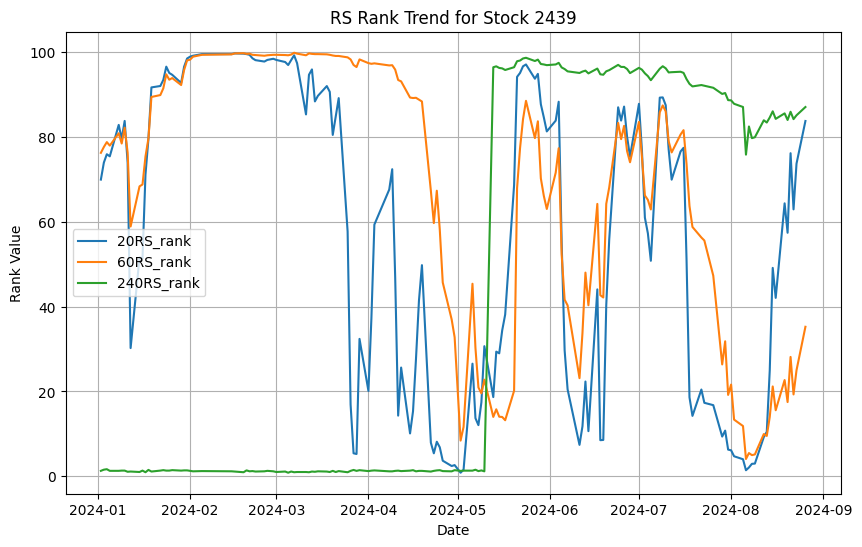

In [7]:
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
stock_df_year = stock_df_raw[(stock_df_raw['Date']>'2024-01-01' ) & (stock_df_raw['Date']<'2024-12-07' )]
# filtered_df = stock_df_year[stock_df_year['證券代號'] == '3715']
# filtered_df['20RS_rank'].head(50)
filtered_df = stock_df_year[stock_df_year['證券代號'] == '3535']
filtered_df.loc[:, '60RS_rank_mean'] = filtered_df['60RS_rank'].rolling(30).mean()

# 60日線的RS千萬不能低於80


import matplotlib.pyplot as plt

# 過濾出符合條件的資料
filtered_df = stock_df_year[stock_df_year['證券代號'] == '6584']
# 如果日期欄位不是索引，將其設定為索引
filtered_df = filtered_df.set_index('Date')
# 繪製折線圖
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['20RS_rank'], label='20RS_rank')
plt.plot(filtered_df.index, filtered_df['60RS_rank'], label='60RS_rank')
plt.plot(filtered_df.index, filtered_df['240RS_rank'], label='240RS_rank')

# 標題和標籤
plt.title('RS Rank Trend for Stock 2439')
plt.xlabel('Date')
plt.ylabel('Rank Value')
plt.legend()

# 顯示圖表
plt.grid(True)
plt.show()


              Date  證券代號  證券名稱      成交股數   成交筆數        成交金額     開盤價     最高價  \
1065906 2023-07-03  3715  定穎投控   4650876   1767   128394162   27.30   27.85   
1067706 2023-07-04  3715  定穎投控   9896900   4228   283044416   27.75   29.25   
1069505 2023-07-05  3715  定穎投控  19063953   7370   577530831   28.90   30.85   
1071304 2023-07-06  3715  定穎投控  34643444  13639  1119858106   30.55   33.35   
1073103 2023-07-07  3715  定穎投控  19572074   8066   612164248   32.25   32.65   
...            ...   ...   ...       ...    ...         ...     ...     ...   
1253510 2023-11-30  3715  定穎投控  46530205  26341  4740589910  100.00  104.00   
1255321 2023-12-01  3715  定穎投控  77766387  40901  8412081453  102.50  112.00   
1257132 2023-12-04  3715  定穎投控  54224028  31503  5666856365  109.00  110.50   
1258942 2023-12-05  3715  定穎投控  27631831  17783  2684470208   99.50   99.70   
1260755 2023-12-06  3715  定穎投控  30882657  21806  3024065193   98.00  100.00   

            最低價     收盤價  ...     60MA      60RS   2

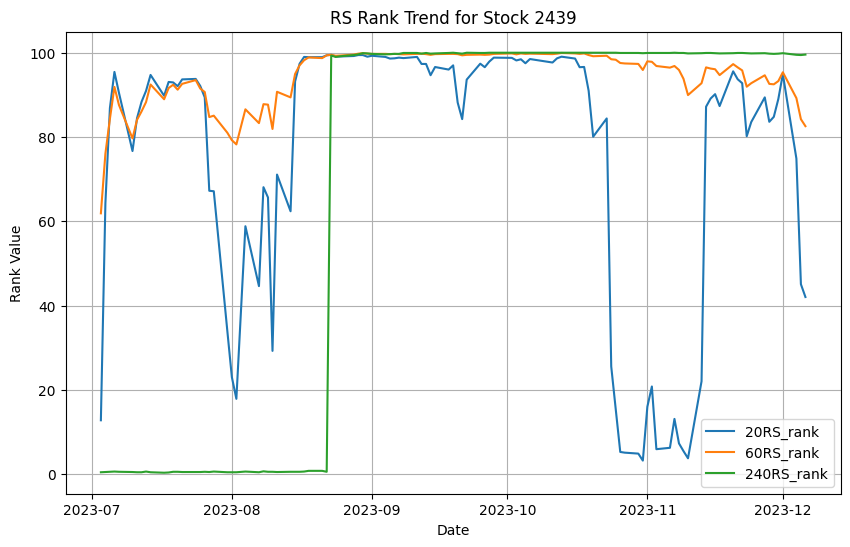

In [ ]:
# # 驗證一下60RS 都大於80的股票是不是表現很好

# today_str = '2023-01-03'
# stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
# stock_df_today = stock_df_raw[stock_df_raw['Date'] == today_str].copy() 

# today_list = stock_df_today[(stock_df_today['成交金額']>500000000)]

# # 計算一年內高點
# stock_id_list = today_list['證券代號'].unique().tolist()

# stock_id_filter = []
# for i in stock_id_list:
#         if((len(i)==4) ): #1. 排除債 ETF等等 2.排除新掛牌資料不到calculate_day天
#                 #print(i)
#                 # 計算個股 RS
#                 temp_df = stock_df_raw[stock_df_raw['證券代號']==i].copy()
#                 temp_df.loc[:, '60RS_rank_min'] = temp_df['60RS_rank'].rolling(30).min()
#                 RS_rank_min = temp_df[temp_df['Date'] == today_str]['60RS_rank_min'].iloc[0]

#                 if(RS_rank_min > 80):
#                     stock_id_filter.append(i) 


# filter_stock_today = stock_df_today[stock_df_today['證券代號'].isin(stock_id_filter)]
# filter_stock_today

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
862793,2023-01-03,1590,亞德客-KY,579307,555,538112678,931.00,944.0,907.0,930.00,...,848.8500,109.5600,1.012958,63.402350,1.074307,85.730274,873.7875,106.4332,1.162682,80.973699
862802,2023-01-03,1605,華新,76317803,32852,3546814012,47.25,47.6,46.0,46.95,...,42.7292,109.8781,1.005697,51.986570,1.077426,86.345831,37.2298,126.1087,1.377618,94.236150
862842,2023-01-03,1760,寶齡富錦,12029307,8188,2140747616,178.50,181.0,175.5,175.50,...,159.6833,109.9050,1.008234,56.183548,1.077690,86.457750,126.4796,138.7576,1.515796,96.586458
862854,2023-01-03,1795,美時,13202785,9303,3303666707,249.50,253.5,247.0,250.50,...,200.0750,125.2030,1.049999,86.849468,1.227697,96.866256,149.1196,167.9860,1.835088,99.048685
862920,2023-01-03,2201,裕隆,17977933,9919,1134026392,62.10,64.1,61.7,63.20,...,54.1375,116.7398,1.018941,71.684387,1.144710,93.508674,45.4231,139.1362,1.519931,96.754337
862952,2023-01-03,2327,國巨,1741813,2314,798582129,450.00,466.5,446.0,465.50,...,410.4250,113.4190,1.002475,46.446558,1.112147,91.214326,393.8083,118.2047,1.291275,90.822608
862959,2023-01-03,2338,光罩,6907751,4396,593569061,84.00,87.9,83.1,87.50,...,74.0933,118.0943,0.999755,41.913822,1.157992,94.348069,80.6450,108.5002,1.185262,84.107443
863236,2023-01-03,3034,聯詠,11770294,12032,3858609275,313.00,334.5,312.5,334.50,...,281.5167,118.8207,1.106110,95.243425,1.165114,94.739787,337.0125,99.2545,1.084262,63.458310
863393,2023-01-03,3454,晶睿,13864170,9830,2748226203,195.00,206.5,189.0,206.50,...,176.9917,116.6722,1.001176,44.208170,1.144047,93.452714,110.0704,187.6072,2.049431,99.328483
863413,2023-01-03,3515,華擎,10907247,8619,1625762023,143.50,152.0,143.5,149.00,...,117.5867,126.7150,1.103308,94.963626,1.242523,96.978176,142.7975,104.3436,1.139855,77.504197


In [67]:
# 這樣是可以撈到華城 可以回測多筆這樣績效卻沒有很好


# day_list = stock_df_raw[(stock_df_raw['Date']>'2022-12-04' ) & (stock_df_raw['Date']<'2022-12-07' )]
# day_list = day_list['Date'].unique().tolist()
# filter_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])


# for day in day_list:
#         today_str = day.strftime('%Y-%m-%d')
#         stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
#         stock_df_today = stock_df_raw[stock_df_raw['Date'] == today_str].copy() 

#         # 收盤在季線以上 年線以上 成值 1億 
#         today_list = stock_df_today[(stock_df_today['收盤價']>stock_df_today['60MA']) & 
#                                 (stock_df_today['60MA']>stock_df_today['240MA']) & 
#                                 (stock_df_today['成交金額']>200000000) &
#                                 (stock_df_today['成交股數']>2000000) & 
#                                 (stock_df_today['60RS_rank']>75) ]

#         # 計算一年內高點
#         stock_id_list = today_list['證券代號'].unique().tolist()
        
#         stock_id_filter = []
#         for i in stock_id_list:
#                 if((len(i)==4) ): #1. 排除債 ETF等等 2.排除新掛牌資料不到calculate_day天

#                         # 計算個股 RS
#                         today_df = stock_df_raw[(stock_df_raw['證券代號']==i) & (stock_df_raw['Date'] == today_str) ].copy()
#                         close = today_df['收盤價'].iloc[0]

#                         #print(i)
#                         # 計算個股 RS
#                         temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==i) & (stock_df_raw['Date'] < today_str)  ].copy()
#                         # 一年內高低點
#                         temp_df_his.loc[:, '240DAY_min'] = temp_df_his['收盤價'].rolling(240).min()
#                         temp_df_his.loc[:, '240DAY_max'] = temp_df_his['收盤價'].rolling(240).max()
#                         temp_df_his.loc[:, '240DAY_money'] = temp_df_his['成交金額'].rolling(120).mean()

#                         DAY240_min = temp_df_his.tail(1)['240DAY_min'].iloc[0]
#                         DAY240_max = temp_df_his.tail(1)['240DAY_max'].iloc[0]
#                         DAY240_money = temp_df_his.tail(1)['240DAY_money'].iloc[0]
#                         MA60 = temp_df_his.tail(1)['60MA'].iloc[0] 
                        
#                         # 計算個股 60日RS rank 從原本小於 80 飆上來 
#                         temp_df_his.loc[:, '60RS_rank_mean'] = temp_df_his['60RS_rank'].rolling(30).mean()
#                         RS_rank_mean = temp_df_his.tail(1)['60RS_rank_mean'].iloc[0]


#                         # RS_rank_min = 90
#                         #距離一年高點25%以內
#                         #距離一年低點20%以上
#                         if( (close*1.2 >  DAY240_max) & (close >  DAY240_min*1.2) & (RS_rank_mean <  50) & (DAY240_money < 150000000) & (close < MA60*1.3)):
#                                 stock_id_filter.append(i) 


#         filter_stock_today = stock_df_today[stock_df_today['證券代號'].isin(stock_id_filter)]
#         filter_stock_today = filter_stock_today[['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價']]
#         if (len(filter_stock_today)!=0):
#                 filter_stock_list = pd.concat([filter_stock_list, filter_stock_today], ignore_index=True)



# filter_stock_list

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,收盤價
0,2022-12-06,1519,華城,16004923,6358,770650186,47.2,48.7


In [208]:
# import pandas as pd
# from multiprocessing import Pool

# def process_day(day, stock_df_raw):
#     today_str = day.strftime('%Y-%m-%d')
#     stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
#     stock_df_today = stock_df_raw[stock_df_raw['Date'] == today_str].copy() 

#     # 收盤在季線以上 年線以上 成值 2億
#     today_list = stock_df_today[(stock_df_today['收盤價'] > stock_df_today['60MA']) & 
#                                 (stock_df_today['60MA'] > stock_df_today['240MA']) & 
#                                 (stock_df_today['成交金額'] > 200000000) &
#                                 (stock_df_today['成交股數'] > 2000000) & 
#                                 (stock_df_today['60RS_rank'] > 75)]

#     stock_id_list = today_list['證券代號'].unique().tolist()
#     stock_id_filter = []

#     for i in stock_id_list:
#         if len(i) == 4:
#             today_df = stock_df_raw[(stock_df_raw['證券代號'] == i) & (stock_df_raw['Date'] == today_str)].copy()
#             close = today_df['收盤價'].iloc[0]

#             temp_df_his = stock_df_raw[(stock_df_raw['證券代號'] == i) & (stock_df_raw['Date'] < today_str)].copy()

#             # 計算一年內高低點
#             DAY240_min = temp_df_his['收盤價'].rolling(240).min().iloc[-1]
#             DAY240_max = temp_df_his['收盤價'].rolling(240).max().iloc[-1]
#             DAY240_money = temp_df_his['成交金額'].rolling(120).mean().iloc[-1]
#             MA60 = temp_df_his['60MA'].iloc[-1]

#             RS_rank_mean = temp_df_his['60RS_rank'].rolling(30).mean().iloc[-1]

#             # RS_rank_min = 90
#             #距離一年高點25%以內 距離一年低點20%以上
#             if (close * 1.2 > DAY240_max) and (close > DAY240_min * 1.2) and (RS_rank_mean < 50) and (DAY240_money < 150000000) and (close < MA60 * 1.3):
#                 stock_id_filter.append(i)

#     filter_stock_today = stock_df_today[stock_df_today['證券代號'].isin(stock_id_filter)]
#     filter_stock_today = filter_stock_today[['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價']]
    
#     return filter_stock_today if not filter_stock_today.empty else None


In [ ]:
# if __name__ == '__main__':
#     day_list = stock_df_raw[(stock_df_raw['Date']>'2022-12-04' ) & (stock_df_raw['Date']<'2022-12-07' )]
#     day_list = day_list['Date'].unique().tolist()

#     with Pool(processes=4) as pool:  # 調整 processes 來匹配 CPU 核心數
#         results = pool.starmap(process_day, [(day, stock_df_raw) for day in day_list])

#     # 將所有結果合併
#     filter_stock_list = pd.concat([res for res in results if res is not None], ignore_index=True)


In [156]:
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
day_list = stock_df_raw[(stock_df_raw['Date']>='2023-03-09' ) & (stock_df_raw['Date']<'2023-07-01' )]
day_list = day_list['Date'].unique().tolist()
filter_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])
 

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        
        stock_df_today = stock_df_raw[stock_df_raw['Date'] == today_str].copy() 

        # 收盤在季線以上 年線以上 成值 1億 
        today_list = stock_df_today[(stock_df_today['收盤價']>stock_df_today['60MA']) & 
                                (stock_df_today['60MA']>stock_df_today['240MA']) & 
                                (stock_df_today['成交金額']>100000000) &
                                (stock_df_today['成交股數']>2000000) & 
                                (stock_df_today['60RS_rank']>75) ]

        # 計算一年內高點
        stock_id_list = today_list['證券代號'].unique().tolist()

        stock_id_filter = []
        for i in stock_id_list:
                if((len(i)==4) ): #1. 排除債 ETF等等 2.排除新掛牌資料不到calculate_day天

                        # 計算個股 RS
                        today_df = stock_df_raw[(stock_df_raw['證券代號']==i) & (stock_df_raw['Date'] == today_str) ].copy()
                        close = today_df['收盤價'].iloc[0]

                        #print(i)
                        # 計算個股 RS
                        temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==i) & (stock_df_raw['Date'] < today_str) & (stock_df_raw['收盤價'] != 0) ].copy()
                        # 一年內高低點
                        temp_df_his.loc[:, '120DAY_min'] = temp_df_his['收盤價'].rolling(120).min()
                        temp_df_his.loc[:, '120DAY_max'] = temp_df_his['收盤價'].rolling(120).max()
                        temp_df_his.loc[:, '120DAY_money'] = temp_df_his['成交金額'].rolling(120).mean()


                        DAY120_min = temp_df_his.tail(1)['120DAY_min'].iloc[0]
                        DAY120_max = temp_df_his.tail(1)['120DAY_max'].iloc[0]


                        DAY240_money = temp_df_his.tail(1)['120DAY_money'].iloc[0]
                        MA20 = temp_df_his.tail(1)['20MA'].iloc[0] 
                        
                        # 計算個股 60日RS rank 從原本小於 80 飆上來 
                        temp_df_his.loc[:, '60RS_rank_mean'] = temp_df_his['60RS_rank'].rolling(30).mean()
                        RS_rank_mean = temp_df_his.tail(1)['60RS_rank_mean'].iloc[0]
                        if (DAY120_min == 0) |  (DAY120_max == 0) :
                                print('DAY240_min = 0 stock_name:' + temp_df_his['證券名稱'].iloc[0] + "today_str" + today_str + "stock_id" + i)
                        else:
                                max_min_diff = abs(DAY120_max - DAY120_min) / DAY120_min 

                                # RS_rank_min = 90
                                #距離一年高點25%以內
                                #距離一年低點20%以上
                                if( (close*1.2 >  DAY120_max) & 
                                (close >  DAY120_min*1.2) & 
                                (RS_rank_mean <  50) & 
                                (DAY240_money < 80000000) & 
                                (close < MA20*1.1) & 
                                (DAY240_money < 80000000) &
                                (max_min_diff < 0.3)):
                                        stock_id_filter.append(i) 


        filter_stock_today = stock_df_today[stock_df_today['證券代號'].isin(stock_id_filter)]
        filter_stock_today = filter_stock_today[['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價']]
        if (len(filter_stock_today)!=0):
                filter_stock_list = pd.concat([filter_stock_list, filter_stock_today], ignore_index=True)


filter_stock_list


,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,收盤價
0,2023-03-10,1339,昭輝,2363188,1769,110362777,44.75,46.45
1,2023-03-15,3038,全台,8123851,3512,198832560,24.35,24.15
2,2023-03-16,4190,佐登-KY,5017107,3930,442868253,85.40,86.10
3,2023-03-21,2387,精元,3767670,2463,162526293,42.60,43.55
4,2023-03-22,2387,精元,2451298,1728,107150720,44.20,43.60
5,2023-03-22,3715,定穎投控,19159920,5584,379071307,19.45,19.55
6,2023-03-28,2331,精英,11548409,4425,273552005,23.55,24.25
7,2023-04-20,3501,維熹,4309832,2896,244953855,55.00,57.60
8,2023-04-21,3501,維熹,4712696,3560,268361560,58.70,55.10
9,2023-04-24,1710,東聯,12152720,4925,255157128,20.40,21.00


In [161]:
today = datetime.now().date()
today.strftime('%Y-%m-%d')

'2024-08-26'

In [162]:
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

day_list = stock_df_raw[(stock_df_raw['Date']>='2024-08-01' ) & (stock_df_raw['Date']<'2024-08-10' )]
day_list = day_list['Date'].unique().tolist()
filter_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價'])


for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = stock_df_raw[stock_df_raw['Date'] == today_str].copy() 

        # 收盤在季線以上 年線以上 成值 1億 
        today_list = stock_df_today[(stock_df_today['收盤價']>stock_df_today['60MA']) & 
                                (stock_df_today['60MA']>stock_df_today['240MA']) & 
                                (stock_df_today['成交金額']>100000000) &
                                (stock_df_today['成交股數']>2000000) & 
                                (stock_df_today['60RS_rank']>75) ]

        # 計算一年內高點
        stock_id_list = today_list['證券代號'].unique().tolist()

        stock_id_filter = []
        for i in stock_id_list:
                if((len(i)==4) ): #1. 排除債 ETF等等 2.排除新掛牌資料不到calculate_day天

                        # 計算個股 RS
                        close = stock_df_raw[(stock_df_raw['證券代號']==i) & (stock_df_raw['Date'] == today_str) ]['收盤價'].iloc[0]

                        #print(i)
                        # 計算個股 RS
                        temp_df_his = stock_df_raw[(stock_df_raw['證券代號']==i) & (stock_df_raw['Date'] < today_str) & (stock_df_raw['收盤價'] != 0) ].copy()
                        # 一年內高低點

                        # temp_df_his.loc[:, '120DAY_min'] = temp_df_his['收盤價'].rolling(120).min()
                        # temp_df_his.loc[:, '120DAY_max'] = temp_df_his['收盤價'].rolling(120).max()
                        # temp_df_his.loc[:, '120DAY_money'] = temp_df_his['成交金額'].rolling(120).mean()


                        # DAY120_min = temp_df_his.tail(1)['120DAY_min'].iloc[0]
                        # DAY120_max = temp_df_his.tail(1)['120DAY_max'].iloc[0]
                        temp_df_his_tail = temp_df_his.tail(120)

                        DAY120_min = temp_df_his_tail['收盤價'].min()
                        DAY120_max = temp_df_his_tail['收盤價'].max()


                        DAY240_money = temp_df_his_tail['成交金額'].mean()
                        MA20 = temp_df_his.tail(1)['20MA'].iloc[0] 
                        
                        # 計算個股 60日RS rank 從原本小於 80 飆上來 
                        # temp_df_his.loc[:, '60RS_rank_mean'] = temp_df_his['60RS_rank'].rolling(30).mean()
                        RS_rank_mean = temp_df_his['60RS_rank'].tail(30).mean()
                        if (DAY120_min == 0) |  (DAY120_max == 0) :
                                print('DAY240_min = 0 stock_name:' + temp_df_his['證券名稱'].iloc[0] + "today_str" + today_str + "stock_id" + i)
                        else:
                                max_min_diff = abs(DAY120_max - DAY120_min) / DAY120_min 

                                # RS_rank_min = 90
                                #距離一年高點25%以內
                                #距離一年低點20%以上
                                if( (close*1.2 >  DAY120_max) & 
                                (close >  DAY120_min*1.2) & 
                                (RS_rank_mean <  50) & 
                                (DAY240_money < 80000000) & 
                                (close < MA20*1.1) & 
                                (DAY240_money < 80000000) &
                                (max_min_diff < 0.3)):
                                        stock_id_filter.append(i) 


        filter_stock_today = stock_df_today[stock_df_today['證券代號'].isin(stock_id_filter)]
        filter_stock_today = filter_stock_today[['Date','證券代號','證券名稱','成交股數','成交筆數', '成交金額','開盤價', '收盤價']]
        if (len(filter_stock_today)!=0):
                filter_stock_list = pd.concat([filter_stock_list, filter_stock_today], ignore_index=True)


filter_stock_list


,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,收盤價
0,2024-08-01,9940,信義,4225914,2955,151651198,34.2,35.8


In [176]:
# filter_stock_list2023 = filter_stock_list
filter_stock_list2023

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,收盤價
0,2023-02-13,6605,帝寶,3053600,2491,245957425,79.30,80.80
1,2023-03-10,1339,昭輝,2363188,1769,110362777,44.75,46.45
2,2023-03-15,3038,全台,8123851,3512,198832560,24.35,24.15
3,2023-03-16,4190,佐登-KY,5017107,3930,442868253,85.40,86.10
4,2023-03-21,2387,精元,3767670,2463,162526293,42.60,43.55
5,2023-03-22,2387,精元,2451298,1728,107150720,44.20,43.60
6,2023-03-22,3715,定穎投控,19159920,5584,379071307,19.45,19.55
7,2023-03-28,2331,精英,11548409,4425,273552005,23.55,24.25
8,2023-04-20,3501,維熹,4309832,2896,244953855,55.00,57.60
9,2023-04-21,3501,維熹,4712696,3560,268361560,58.70,55.10


In [157]:
# Q1 森鉅 撈出來之後如何停損
filter_stock_list

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,收盤價
0,2023-03-10,1339,昭輝,2363188,1769,110362777,44.75,46.45
1,2023-03-15,3038,全台,8123851,3512,198832560,24.35,24.15
2,2023-03-16,4190,佐登-KY,5017107,3930,442868253,85.40,86.10
3,2023-03-21,2387,精元,3767670,2463,162526293,42.60,43.55
4,2023-03-22,2387,精元,2451298,1728,107150720,44.20,43.60
5,2023-03-22,3715,定穎投控,19159920,5584,379071307,19.45,19.55
6,2023-03-28,2331,精英,11548409,4425,273552005,23.55,24.25
7,2023-04-20,3501,維熹,4309832,2896,244953855,55.00,57.60
8,2023-04-21,3501,維熹,4712696,3560,268361560,58.70,55.10
9,2023-04-24,1710,東聯,12152720,4925,255157128,20.40,21.00


In [158]:
#短側一個月效果不明顯  之後側一年看看
df_unique = filter_stock_list.drop_duplicates(subset='證券代號', keep='first')
print(df_unique)


         Date  證券代號   證券名稱      成交股數  成交筆數       成交金額    開盤價    收盤價
0  2023-03-10  1339     昭輝   2363188  1769  110362777  44.75  46.45
1  2023-03-15  3038     全台   8123851  3512  198832560  24.35  24.15
2  2023-03-16  4190  佐登-KY   5017107  3930  442868253  85.40  86.10
3  2023-03-21  2387     精元   3767670  2463  162526293  42.60  43.55
5  2023-03-22  3715   定穎投控  19159920  5584  379071307  19.45  19.55
6  2023-03-28  2331     精英  11548409  4425  273552005  23.55  24.25
7  2023-04-20  3501     維熹   4309832  2896  244953855  55.00  57.60
9  2023-04-24  1710     東聯  12152720  4925  255157128  20.40  21.00
12 2023-04-27  1789     神隆   4620096  2137  129967842  27.55  28.30
13 2023-04-27  1904     正隆   6452612  4179  202265604  31.85  31.35
14 2023-04-27  6412     群電   3413734  2674  293006953  83.10  86.50
15 2023-04-27  8403     盛弘   7773203  4631  286016768  35.10  36.95
19 2023-05-02  2417     圓剛   5292704  3097  134699255  25.45  25.45
21 2023-05-03  4173     久裕   4977420  2544  1081

In [159]:
import warnings
# 計算出場  使用60RS看看
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

RS_down = list(range(70, 80, 1))

profolio_df1 = pd.DataFrame(columns=['rs_value', 'mean', 'mean_t1', 'mean_t2','hold_day_mean1','hold_day_mean2'])

for rs_value in RS_down:
    collected_data = pd.DataFrame(columns=['rs_value','stock_id', 'stock_name', 'Date', '收盤價', '隔天收盤價', '收盤價_RS小於75','隔天開盤_RS小於75', '收盤價_dff','隔日開盤價_dff','收盤價_隔天收盤_dff','收盤價_隔天開盤_dff','持有天數1','持有天數2'])
    
    for i in range(len(df_unique)):
        temp_df = df_unique.iloc[i].copy()

        filter_day = pd.to_datetime(temp_df['Date'])
        # filter_day30 = filter_day + pd.Timedelta(days=hold_day)
        filter_stock_id = temp_df['證券代號']


        # 篩到之後 隔天一開盤要買 (回測起來 隔天收盤買效果好像更好ㄟ)

        tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['收盤價'].iloc[0]
        # tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]

        # 找到跌落RS後 不可能那天開盤價可以賣 要重測一次
        RS75_df_t = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['60RS_rank'] < rs_value)].copy()
        getout_day = RS75_df_t['Date'].iloc[0]
        RS75_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > getout_day.strftime('%Y-%m-%d'))].copy()

        

        if RS75_df.empty:
            continue

        stock_df_RS750 = RS75_df.iloc[0] # 符合條件當天收盤賣
        stock_df_RS751 = RS75_df.iloc[1] # 符合條件隔天開盤再賣

        diff_day1 = (stock_df_RS750['Date'] - temp_df['Date']).days

        diff1 = round(100 * (stock_df_RS750['收盤價'] / temp_df['收盤價'] - 1), 2) #撈出來當天
        diff_t1 = round(100 * (stock_df_RS750['收盤價'] / tomorrow_open - 1), 2)  #撈出來隔天

        diff_day2 = (stock_df_RS751['Date'] - temp_df['Date']).days

        diff2 = round(100 * (stock_df_RS751['開盤價'] / temp_df['收盤價'] - 1), 2)
        diff_t2 = round(100 * (stock_df_RS751['開盤價'] / tomorrow_open - 1), 2)


        result_df = pd.DataFrame({
            'rs_value': [rs_value],
            'stock_id': [filter_stock_id],
            'stock_name': [temp_df['證券名稱']],
            'Date': [temp_df['Date']],
            '收盤價': [temp_df['收盤價']],
            '隔天收盤價': [tomorrow_open],
            '收盤價_RS小於75': [stock_df_RS750['收盤價']],
            '隔天開盤_RS小於75': [stock_df_RS751['收盤價']],
            '收盤價_dff': [diff1],
            '隔日開盤價_dff': [diff2],
            '收盤價_隔天收盤_dff': [diff_t1],
            '收盤價_隔天開盤_dff': [diff_t2],
            '持有天數1': [diff_day1],
            '持有天數2': [diff_day2]
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)

        if not result_df.empty:
            collected_data = pd.concat([collected_data, result_df], ignore_index=True)

    # 仅当collected_data不为空时，计算mean并合并到profolio_df中
    if not collected_data.empty:
        mean = collected_data['收盤價_dff'].mean()
        mean_t1 = collected_data['收盤價_隔天收盤_dff'].mean()
        mean_t2 = collected_data['收盤價_隔天開盤_dff'].mean()
        hold_day_mean1 = collected_data['持有天數1'].mean()
        hold_day_mean2 = collected_data['持有天數2'].mean()
        profolio_data = pd.DataFrame({
            'rs_value': [rs_value],
            'mean': [mean],
            'mean_t1': [mean_t1],
            'mean_t2': [mean_t2],
            'hold_day_mean1' : [hold_day_mean1],
            'hold_day_mean2' : [hold_day_mean2],
        })
        profolio_df1 = pd.concat([profolio_df1, profolio_data], ignore_index=True)
        
profolio_df1['pen1'] = profolio_df1['mean']/ profolio_df1['hold_day_mean1']
profolio_df1['pen_t1'] = profolio_df1['mean_t1']/ profolio_df1['hold_day_mean1']

profolio_df1['pen2'] = profolio_df1['mean']/ profolio_df1['hold_day_mean2']
profolio_df1['pen_t2'] = profolio_df1['mean_t2']/ profolio_df1['hold_day_mean2']

profolio_df1['diff_pen1'] = profolio_df1['mean_t1'] - profolio_df1['mean']
profolio_df1['diff_pen2'] = profolio_df1['mean_t2'] - profolio_df1['mean']

print('======profolio_df1======diff_pen=================')
print(profolio_df1['diff_pen1'].mean())
print(profolio_df1['diff_pen2'].mean())
profolio_df1


======profolio_df1======diff_pen=================
0.40686956521739076
0.840434782608696


,rs_value,mean,mean_t1,mean_t2,hold_day_mean1,hold_day_mean2,pen1,pen_t1,pen2,pen_t2,diff_pen1,diff_pen2
0,70,8.612609,9.029130,9.404783,31.869565,33.043478,0.270246,0.283315,0.260645,0.284618,0.416522,0.792174
1,71,8.422609,8.840000,9.135652,31.565217,32.826087,0.266832,0.280055,0.256583,0.278305,0.417391,0.713043
2,72,8.957826,9.375652,9.744348,30.521739,31.782609,0.293490,0.307179,0.281847,0.306594,0.417826,0.786522
3,73,8.963043,9.373913,9.722174,29.956522,31.260870,0.299202,0.312917,0.286718,0.311001,0.410870,0.759130
4,74,7.690870,8.092609,8.628696,25.260870,26.521739,0.304458,0.320361,0.289984,0.325344,0.401739,0.937826
5,75,7.822609,8.223478,8.728696,23.826087,25.086957,0.328321,0.345146,0.311820,0.347938,0.400870,0.906087
6,76,7.471739,7.867826,8.348696,22.782609,24.043478,0.327958,0.345344,0.310759,0.347233,0.396087,0.876957
7,77,2.960870,3.404348,3.959130,17.347826,18.608696,0.170677,0.196241,0.159112,0.212757,0.443478,0.998261
8,78,0.550870,0.932609,1.371304,11.521739,12.695652,0.047811,0.080943,0.043390,0.108014,0.381739,0.820435
9,79,0.585217,0.967391,1.399130,10.652174,11.826087,0.054939,0.090816,0.049485,0.118309,0.382174,0.813913


In [153]:
collected_data

,rs_value,stock_id,stock_name,Date,收盤價,隔天收盤價,收盤價_RS小於75,隔天開盤_RS小於75,收盤價_dff,隔日開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,持有天數1,持有天數2
0,70,1339,昭輝,2023-03-10,46.45,49.05,44.15,44.75,-4.95,-3.66,-9.99,-8.77,6,7
1,70,3038,全台,2023-03-15,24.15,23.50,36.65,39.25,51.76,51.97,55.96,56.17,121,124
2,70,4190,佐登-KY,2023-03-16,86.10,83.80,83.30,85.10,-3.25,-2.56,-0.60,0.12,5,6
3,70,3402,漢科,2023-03-17,49.55,50.70,52.10,52.40,5.15,5.15,2.76,2.76,47,48
4,70,2387,精元,2023-03-21,43.55,43.60,40.00,40.80,-8.15,-8.96,-8.26,-9.06,51,52
5,70,3715,定穎投控,2023-03-22,19.55,19.95,27.00,27.20,38.11,40.15,35.34,37.34,98,99
6,70,4306,炎洲,2023-03-22,16.25,16.25,16.40,16.25,0.92,1.54,0.92,1.54,5,6
7,70,2392,正崴,2023-03-24,42.85,41.70,41.40,41.95,-3.38,-3.03,-0.72,-0.36,4,5
8,70,2331,精英,2023-03-28,24.25,23.30,22.95,22.75,-5.36,-4.74,-1.50,-0.86,2,3
9,70,3501,維熹,2023-04-20,57.60,55.10,55.10,55.90,-4.34,-4.51,0.00,-0.18,5,6


In [155]:
collected_data

,rs_value,stock_id,stock_name,Date,收盤價,隔天收盤價,收盤價_RS小於75,隔天開盤_RS小於75,收盤價_dff,隔日開盤價_dff,收盤價_隔天收盤_dff,收盤價_隔天開盤_dff,持有天數1,持有天數2
0,75,1339,昭輝,2023-03-10,46.45,49.05,45.45,44.15,-2.15,-1.72,-7.34,-6.93,5,6
1,75,3038,全台,2023-03-15,24.15,23.50,36.65,39.25,51.76,51.97,55.96,56.17,121,124
2,75,4190,佐登-KY,2023-03-16,86.10,83.80,84.10,83.30,-2.32,-2.09,0.36,0.60,4,5
3,75,3402,漢科,2023-03-17,49.55,50.70,50.70,52.20,2.32,2.93,0.00,0.59,5,6
4,75,2387,精元,2023-03-21,43.55,43.60,44.45,45.00,2.07,2.30,1.95,2.18,21,22
5,75,3715,定穎投控,2023-03-22,19.55,19.95,27.00,27.20,38.11,40.15,35.34,37.34,98,99
6,75,4306,炎洲,2023-03-22,16.25,16.25,16.10,16.40,-0.92,0.00,-0.92,0.00,2,5
7,75,2392,正崴,2023-03-24,42.85,41.70,41.40,41.95,-3.38,-3.03,-0.72,-0.36,4,5
8,75,2331,精英,2023-03-28,24.25,23.30,22.95,22.75,-5.36,-4.74,-1.50,-0.86,2,3
9,75,3501,維熹,2023-04-20,57.60,55.10,55.10,55.90,-4.34,-4.51,0.00,-0.18,5,6


In [55]:
print('======profolio_df1======diff_pen=================')
print(profolio_df1['diff_pen1'].mean())
print(profolio_df1['diff_pen2'].mean())
profolio_df1

======profolio_df1======diff_pen=================
-0.6657619047619043
2.0593333333333335


,rs_value,mean,mean_t1,mean_t2,hold_day_mean1,hold_day_mean2,pen1,pen_t1,pen2,pen_t2,diff_pen1,diff_pen2
0,60,10.092857,9.429286,9.632857,58.928571,63.357143,0.171273,0.160012,0.159301,0.152041,-0.663571,-0.460000
1,61,9.692857,9.027857,9.892857,58.000000,63.071429,0.167118,0.155653,0.153681,0.156852,-0.665000,0.200000
2,62,9.190714,8.520000,10.737143,50.714286,62.500000,0.181225,0.168000,0.147051,0.171794,-0.670714,1.546429
3,63,7.292857,6.625000,10.817143,41.500000,60.857143,0.175731,0.159639,0.119836,0.177746,-0.667857,3.524286
4,64,7.454286,6.783571,11.076429,41.000000,60.714286,0.181812,0.165453,0.122776,0.182435,-0.670714,3.622143
5,65,7.454286,6.783571,11.172857,41.000000,60.642857,0.181812,0.165453,0.122921,0.184240,-0.670714,3.718571
6,66,7.427143,6.755714,10.468571,40.857143,53.642857,0.181783,0.165350,0.138455,0.195153,-0.671429,3.041429
7,67,8.035714,7.357857,9.972857,40.642857,50.214286,0.197715,0.181037,0.160028,0.198606,-0.677857,1.937143
8,68,8.035714,7.357857,9.842857,40.642857,50.142857,0.197715,0.181037,0.160256,0.196296,-0.677857,1.807143
9,69,8.035714,7.357857,10.112857,40.642857,49.785714,0.197715,0.181037,0.161406,0.203128,-0.677857,2.077143


In [69]:
import warnings
# 計算出場  用持有天數來看看
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

filter_days = list(range(10, 101, 10)) # 持有天數
# filter_days = list(range(3, 10, 1)) # 持有天數

profolio_df2 = pd.DataFrame(columns=['day', 'mean'])

for hold_day in filter_days:
    collected_data = pd.DataFrame(columns=['stock_id', 'stock_name', 'Date', '收盤價','隔天收盤價', '收盤價_30天', '收盤價_dff','收盤價_隔天收盤_dff'])
    
    for i in range(len(filter_stock_list)):
        temp_df = filter_stock_list.iloc[i].copy()

        filter_day = pd.to_datetime(temp_df['Date'])
        filter_day30 = filter_day + pd.Timedelta(days=hold_day)
        filter_stock_id = temp_df['證券代號']

        filter_day30 = filter_day30.strftime('%Y-%m-%d')

        

        tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['收盤價'].iloc[0]
        # tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]
        
        month_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] >= filter_day30)].copy()

        if month_df.empty:
            continue

        stock_df_month = month_df.iloc[0]
        diff = round(100 * (stock_df_month['收盤價'] / temp_df['收盤價'] - 1), 2)
        diff_t = round(100 * (stock_df_month['收盤價'] / tomorrow_open - 1), 2)

        result_df = pd.DataFrame({
            'stock_id': [filter_stock_id],
            'stock_name': [temp_df['證券名稱']],
            'Date': [temp_df['Date']],
            '收盤價': [temp_df['收盤價']],
            '隔天收盤價': [tomorrow_open],
            '收盤價_30天': [stock_df_month['收盤價']],
            '收盤價_dff': [diff],
            '收盤價_隔天收盤_dff' : [diff_t],
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)

        if not result_df.empty:
            collected_data = pd.concat([collected_data, result_df], ignore_index=True)

    # 仅当collected_data不为空时，计算mean并合并到profolio_df中
    if not collected_data.empty:
        mean = collected_data['收盤價_dff'].mean()
        mean_t = collected_data['收盤價_隔天收盤_dff'].mean()
        profolio_data = pd.DataFrame({
            'day': [hold_day],
            'mean': [mean],
            'mean_t': [mean_t]
        })
        profolio_df2 = pd.concat([profolio_df2, profolio_data], ignore_index=True)
        
profolio_df2['pen'] = profolio_df2['mean']/ profolio_df2['day']
profolio_df2['pen_t'] = profolio_df2['mean_t']/ profolio_df2['day']
profolio_df2['diff_pen'] = profolio_df2['mean_t'] - profolio_df2['mean']
print('======profolio_df2======diff_pen=================')
print(profolio_df2['diff_pen'].mean())
profolio_df2

======profolio_df2======diff_pen=================
2.8942857142857146


,day,mean,mean_t,pen,pen_t,diff_pen
0,3,-2.066667,-0.616667,-0.688889,-0.205556,1.45
1,4,-4.070000,-2.400000,-1.0175,-0.6,1.67
2,5,-10.060000,-6.670000,-2.012,-1.334,3.39
3,6,-8.380000,-4.930000,-1.396667,-0.821667,3.45
4,7,-9.780000,-6.380000,-1.397143,-0.911429,3.40
5,8,-8.660000,-5.220000,-1.0825,-0.6525,3.44
6,9,-8.100000,-4.640000,-0.9,-0.515556,3.46


In [ ]:
import warnings
# 計算出場   融合兩個看看有沒有比較好
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# 雙重條件
RS_down = list(range(60, 75, 1))
filter_days = list(range(3, 10, 1)) # 持有天數


profolio_df1 = pd.DataFrame(columns=['rs_value', 'mean', 'mean_t1', 'mean_t2','hold_day_mean1','hold_day_mean2'])

for rs_value in RS_down:
    collected_data = pd.DataFrame(columns=['rs_value','stock_id', 'stock_name', 'Date', '收盤價', '隔天收盤價', '收盤價_RS小於75','隔天開盤_RS小於75', '收盤價_dff','隔日開盤價_dff','收盤價_隔天收盤_dff','收盤價_隔天開盤_dff','持有天數1','持有天數2'])
    
    for i in range(len(df_unique)):
        temp_df = df_unique.iloc[i].copy()

        filter_day = pd.to_datetime(temp_df['Date'])
        # filter_day30 = filter_day + pd.Timedelta(days=hold_day)
        filter_stock_id = temp_df['證券代號']


        # 篩到之後 隔天一開盤要買 (回測起來 隔天收盤買效果好像更好ㄟ)

        tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['收盤價'].iloc[0]
        # tomorrow_open = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0]


        #看RS
        RS75_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] > filter_day.strftime('%Y-%m-%d')) & (stock_df_raw['60RS_rank'] < rs_value)].copy()

        if RS75_df.empty:
            continue

        # 看持有天數
        month_df = stock_df_raw[(stock_df_raw['證券代號'] == filter_stock_id) & (stock_df_raw['Date'] >= filter_day30)].copy()

        if month_df.empty:
            continue

        stock_df_month = month_df.iloc[0]



        stock_df_RS750 = RS75_df.iloc[0] # 符合條件當天收盤賣
        stock_df_RS751 = RS75_df.iloc[1] # 符合條件隔天開盤再賣

        diff_day1 = (stock_df_RS750['Date'] - temp_df['Date']).days

        diff1 = round(100 * (stock_df_RS750['收盤價'] / temp_df['收盤價'] - 1), 2) #撈出來當天
        diff_t1 = round(100 * (stock_df_RS750['收盤價'] / tomorrow_open - 1), 2)  #撈出來隔天

        diff_day2 = (stock_df_RS751['Date'] - temp_df['Date']).days

        diff2 = round(100 * (stock_df_RS751['開盤價'] / temp_df['收盤價'] - 1), 2)
        diff_t2 = round(100 * (stock_df_RS751['開盤價'] / tomorrow_open - 1), 2)


        result_df = pd.DataFrame({
            'rs_value': [rs_value],
            'stock_id': [filter_stock_id],
            'stock_name': [temp_df['證券名稱']],
            'Date': [temp_df['Date']],
            '收盤價': [temp_df['收盤價']],
            '隔天收盤價': [tomorrow_open],
            '收盤價_RS小於75': [stock_df_RS750['收盤價']],
            '隔天開盤_RS小於75': [stock_df_RS751['收盤價']],
            '收盤價_dff': [diff1],
            '隔日開盤價_dff': [diff2],
            '收盤價_隔天收盤_dff': [diff_t1],
            '收盤價_隔天開盤_dff': [diff_t2],
            '持有天數1': [diff_day1],
            '持有天數2': [diff_day2]
        })

        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)

        if not result_df.empty:
            collected_data = pd.concat([collected_data, result_df], ignore_index=True)

    # 仅当collected_data不为空时，计算mean并合并到profolio_df中
    if not collected_data.empty:
        mean = collected_data['收盤價_dff'].mean()
        mean_t1 = collected_data['收盤價_隔天收盤_dff'].mean()
        mean_t2 = collected_data['收盤價_隔天開盤_dff'].mean()
        hold_day_mean1 = collected_data['持有天數1'].mean()
        hold_day_mean2 = collected_data['持有天數2'].mean()
        profolio_data = pd.DataFrame({
            'rs_value': [rs_value],
            'mean': [mean],
            'mean_t1': [mean_t1],
            'mean_t2': [mean_t2],
            'hold_day_mean1' : [hold_day_mean1],
            'hold_day_mean2' : [hold_day_mean2],
        })
        profolio_df3 = pd.concat([profolio_df3, profolio_data], ignore_index=True)
        
profolio_df3['pen1'] = profolio_df3['mean']/ profolio_df3['hold_day_mean1']
profolio_df3['pen_t1'] = profolio_df3['mean_t1']/ profolio_df3['hold_day_mean1']

profolio_df3['pen2'] = profolio_df3['mean']/ profolio_df3['hold_day_mean2']
profolio_df3['pen_t2'] = profolio_df3['mean_t2']/ profolio_df3['hold_day_mean2']

profolio_df3['diff_pen1'] = profolio_df3['mean_t1'] - profolio_df3['mean']
profolio_df3['diff_pen2'] = profolio_df3['mean_t2'] - profolio_df3['mean']

print('======profolio_df3======diff_pen=================')
print(profolio_df3['diff_pen1'].mean())
print(profolio_df3['diff_pen2'].mean())
profolio_df3



In [35]:
profolio_df1

,rs_value,mean,mean_t,hold_day_mean,pen,pen_t,diff_pen
0,60,10.218571,10.404286,61.285714,0.166737,0.169767,0.185714
1,61,10.341429,10.525714,59.857143,0.172768,0.175847,0.184286
2,62,10.341429,10.525714,59.857143,0.172768,0.175847,0.184286
3,63,9.362857,9.544286,52.714286,0.177615,0.181057,0.181429
4,64,10.157143,10.365714,50.000000,0.203143,0.207314,0.208571
5,65,9.742857,9.945714,48.714286,0.200000,0.204164,0.202857
6,66,9.742857,9.945714,48.714286,0.200000,0.204164,0.202857
7,67,9.948571,10.154286,48.571429,0.204824,0.209059,0.205714
8,68,10.204286,10.411429,48.428571,0.210708,0.214985,0.207143
9,69,10.220000,10.424286,46.714286,0.218777,0.223150,0.204286


In [ ]:
###===============================#####
# 算每天新進名單及退出名單

In [6]:
# today = datetime.now().date()
# today_str = today.strftime('%Y-%m-%d')
today_str = '2024-08-15'
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
stock_df_today = stock_df_raw[stock_df_raw['Date'] == today_str].copy() 

today_list = stock_df_today[(stock_df_today['收盤價']>stock_df_today['60MA']) & 
                            (stock_df_today['60MA']>stock_df_today['240MA']) & 
                            (stock_df_today['成交金額']>500000000) &
                            (stock_df_today['成交股數']>2000) &
                            (stock_df_today['60RS_rank']>90)]

# 計算一年內高點
stock_id_list = today_list['證券代號'].unique().tolist()

stock_id_filter = []
for i in stock_id_list:
        if((len(i)==4) ): #1. 排除債 ETF等等 2.排除新掛牌資料不到calculate_day天
                #print(i)
                # 計算個股 RS
                temp_df = stock_df_raw[stock_df_raw['證券代號']==i].copy()
                temp_df.loc[:, '240DAY_min'] = temp_df['收盤價'].rolling(240).min()
                temp_df.loc[:, '240DAY_max'] = temp_df['收盤價'].rolling(240).max()
                DAY240_min = temp_df[temp_df['Date'] == today_str]['240DAY_min'].iloc[0]
                DAY240_max = temp_df[temp_df['Date'] == today_str]['240DAY_max'].iloc[0]
                close = temp_df[temp_df['Date'] == today_str]['收盤價'].iloc[0]
                #距離一年高點25%以內
                #距離一年低點20%以上
                if( (close*1.25 >  DAY240_max) & (close >  DAY240_min*1.2)):
                        stock_id_filter.append(i) 


filter_stock_before = stock_df_today[stock_df_today['證券代號'].isin(stock_id_filter)]



today_str = '2024-08-05'
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
stock_df_today = stock_df_raw[stock_df_raw['Date'] == today_str].copy() 

today_list = stock_df_today[(stock_df_today['收盤價']>stock_df_today['60MA']) & 
                            (stock_df_today['60MA']>stock_df_today['240MA']) & 
                            (stock_df_today['成交金額']>500000000) &
                            (stock_df_today['成交股數']>2000) &
                            (stock_df_today['20RS_rank']>90) & 
                            (stock_df_today['240RS_rank']<80) ]

# 計算一年內高點
stock_id_list = today_list['證券代號'].unique().tolist()

stock_id_filter = []
for i in stock_id_list:
        if((len(i)==4) ): #1. 排除債 ETF等等 2.排除新掛牌資料不到calculate_day天
                #print(i)
                # 計算個股 RS
                temp_df = stock_df_raw[stock_df_raw['證券代號']==i].copy()
                temp_df.loc[:, '240DAY_min'] = temp_df['收盤價'].rolling(240).min()
                temp_df.loc[:, '240DAY_max'] = temp_df['收盤價'].rolling(240).max()
                DAY240_min = temp_df[temp_df['Date'] == today_str]['240DAY_min'].iloc[0]
                DAY240_max = temp_df[temp_df['Date'] == today_str]['240DAY_max'].iloc[0]
                close = temp_df[temp_df['Date'] == today_str]['收盤價'].iloc[0]
                #距離一年高點25%以內
                #距離一年低點20%以上
                if( (close*1.25 >  DAY240_max) & (close >  DAY240_min*1.2)):
                        stock_id_filter.append(i) 


filter_stock_today = stock_df_today[stock_df_today['證券代號'].isin(stock_id_filter)]
filter_stock_today

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
844389,2024-08-05,4904,遠傳,18665389,11170,1617436928,85.4,87.4,84.7,87.4,...,84.6433,103.2568,1.19501,96.758509,1.163385,91.247974,79.4192,110.049,1.054881,77.903836


In [4]:
list_now = list(filter_stock_before['證券代號'])
list_before = list(filter_stock_today['證券代號'])
compare_add = [x for x in list_now if x not in list_before] #新進入名單
compare_remove = [x for x in list_before if x not in list_now] #新進入名單

stock_df_today[stock_df_today['證券代號'].isin(compare_add)]

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
858295,2024-08-15,1536,和大,7129083,6050,482363043,69.20,69.3,66.30,67.30,...,61.2533,109.8716,1.023210,76.835853,1.124157,90.874730,59.2775,113.5338,0.994284,74.136069
858338,2024-08-15,1708,東鹼,7593898,5117,288844387,38.25,38.9,37.50,37.75,...,34.3508,109.8954,1.081543,92.278618,1.124400,90.928726,32.4377,116.3769,1.019183,76.997840
858502,2024-08-15,2363,矽統,5211819,5947,362582439,70.00,70.5,68.50,69.20,...,60.4983,114.3833,1.085468,92.764579,1.170318,92.926566,49.1663,140.7470,1.232606,91.684665
858725,2024-08-15,2915,潤泰全,5390917,5370,429291891,80.50,81.0,79.00,79.00,...,72.5817,108.8429,1.017685,73.488121,1.113632,89.956803,63.8583,123.7113,1.083414,82.883369
858958,2024-08-15,3535,晶彩科,8056463,6112,523583160,67.00,67.3,63.20,63.80,...,51.0575,124.9572,0.910497,5.183585,1.278506,96.760259,28.0644,227.3345,1.990905,99.082073
859617,2024-08-15,6535,順藥,1824878,3075,462833684,245.00,260.0,242.00,260.00,...,209.8417,123.9029,1.201585,98.272138,1.267719,96.544276,133.8325,194.2727,1.701363,97.732181
859810,2024-08-15,8043,蜜望實,6357707,3307,280450799,42.10,45.1,41.65,45.10,...,27.0892,166.4872,1.451850,99.946004,1.703422,99.568035,26.7038,168.8901,1.479072,95.788337


In [10]:
import collections
df_rs70_category_week = pd.DataFrame()  #多筆每日強勢細產業

sub_category_list.rename(columns={'stock_id': '證券代號'}, inplace=True)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
data_date_list = collections.Counter(stock_df_raw['Date'].sort_values(ascending=False))

for day in data_date_list:
        day = day.strftime('%Y-%m-%d')
        # 取每天RS大於90的產業出來
        stock_df_today = stock_df_raw[stock_df_raw['Date']==day].copy()  
        stock_df_today.sort_values(by=['60RS_rank'], inplace=True)

        stock_df_today90 = stock_df_today[stock_df_today['60RS_rank']>90]

        merged_rs_sub = pd.merge(stock_df_today90, sub_category_list, on='證券代號', how='inner')  #RS超過90的
        merged_sub = pd.merge(stock_df_today, sub_category_list, on='證券代號', how='inner')  # 全部股票

        cols = ['Date', '證券代號', 'stock_name','60RS_rank','main_category','sub_category']
        merged_rs_sub = merged_rs_sub[cols]
        merged_sub = merged_sub[cols]

        #找細產業別 跟 母體
        df_rs70_sub_category = collections.Counter(merged_rs_sub['sub_category'])
        df_all_sub_category = collections.Counter(merged_sub['sub_category'])

        df_sub_category = pd.DataFrame()
        for i in df_rs70_sub_category:
                sub_category = {
                "date": [day],
                "sub_category": [i],
                "main_rank": [df_rs70_sub_category[i]],
                "all": [df_all_sub_category[i]],
                "pen": [round((df_rs70_sub_category[i]/df_all_sub_category[i])*100,2)]}

                df_sub_category_temp = pd.DataFrame(sub_category)
                df_sub_category = pd.concat([df_sub_category,df_sub_category_temp])
                df_sub_category.sort_values(by=['pen'], ascending=False, inplace=True)

        df_rs70_category_week = pd.concat([df_rs70_category_week,df_sub_category])

                


In [ ]:
# 個股濾網 (技術面)

#股價大於 60MA

#twse_df_raw
#stock_df_raw
#sub_category_list





